In [1656]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, 
                                   PolynomialFeatures, StandardScaler,
                                   label_binarize)
from scipy.sparse import csr_matrix

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from skopt import gp_minimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.base import BaseEstimator, RegressorMixin

from importlib import reload
    
import trainers as tr
import price_calculations as pr
import neural_models as nm
import xgboost as xgb

import matplotlib.pyplot as plt

In [1657]:
# Reload Trainers due to possibility of local changes
reload(tr)
reload(pr)
reload(nm)

<module 'neural_models' from 'C:\\Users\\aflyn\\repos\\Boeing_ML_Pred\\vehicle_predictions\\neural_models.py'>

In [1658]:
def engineerTestData(df,log_cols,encoded_cols,freq_cols,
                     mask_cols,token_cols,orig_cols, feats_to_drop,
                     coder,token_1,token_2):
    df.columns =  df.columns.str.lower()
    df.columns = [col.strip() for col in df.columns]
    df.set_index('listingid',inplace=True)
    df = df.apply(lambda col: col.fillna('Unknown') if col.dtype == 'O' else col.fillna(0))
    
    [df.__setitem__(col, np.log(np.ceil(df[col]))) for col in log_cols]
    [df.__setitem__(col, df[col].map(df[col].value_counts())) for col in freq_cols]
    [df.__setitem__(col, df[col].astype(int)) for col in mask_cols]

    handle_encode = orig_cols 
    test_encode = df[encoded_cols]
    for col in handle_encode:
        col = col.strip()   
        func_name = 'handle_' + col  # Prepare function name
        if func_name in globals() and callable(globals()[func_name]):
            func = globals()[func_name]
            if col == 'vehdrivetrain':
                temp_df = func(df[col].copy())  # Call the function dynamically
                test_encode[col] = temp_df
            elif col == 'vehhistory':
                df.loc[df[col] == 'Unknown', col] = 0
                temp_df = df[col].copy().str.split(',',n=1,expand=True)
                temp_df.columns = ['Owners', 'History']
                temp_df['Owners'] = temp_df['Owners'].str.extract(r'^(\d+)')
                encoded_hist = func(temp_df['History'])  # Call the function dynamically
                df['owners'] = temp_df['Owners']
                df[encoded_hist.columns] = encoded_hist
            elif col == 'vehengine':
                temp_df = func(df[col].copy())  # Call the function dynamically
                temp_df.columns = temp_df.columns.str.lower()
                df[temp_df.columns] = temp_df
            elif col == 'vehcolorext':
                col_temp = func(df[col].copy())  # Call the function dynamically
                col_temp.columns = col_temp.columns.str.lower()
            elif col == 'vehcolorint':
                col_tmp = func(df[col].copy())  # Call the function dynamically
                col_tmp.columns = col_tmp.columns.str.lower()            
        else:
            print(f"Function '{func_name}' does not exist or is not callable.")

    colors = pd.merge(col_temp,col_tmp,left_index=True, right_index=True)
    df = pd.merge(df,colors,left_index=True, right_index=True)
    temp_encoded = oHotEncode(test_encode,coder)
    df.drop(columns=encoded_cols,inplace=True)
    df = pd.merge(df,temp_encoded,left_index=True, right_index=True)
    df.columns = df.columns.astype(str)

    tf1 = tf_idfTokenizer(df[token_cols[0]].copy(),token_1)
    tf2 = tf_idfTokenizer(df[token_cols[1]].copy(),token_2)
    #tfs = pd.concat([tf1, tf2])
    #tfs = combined_tf.loc[:,~combined_tf.columns.duplicated()] 
    tfs = pd.merge(tf1, tf2,left_index=True,right_index=True)
    df = pd.merge(df,tfs,left_index=True,right_index=True)
    df.drop(columns=feats_to_drop,inplace=True)
    
    return df
    
def oHotEncode(df_,coder):
    encoded_mat = coder.transform(df_)
    return pd.DataFrame(encoded_mat.todense(),
                        columns=[cat for columns in coder.categories_ for cat in columns],
                        index=df_.index)

    
def zScoreTransform(col):
    return np.divide(np.subtract(col,col.mean()),col.std())

    
def tf_idfTokenizer(df_,tfidf):
    tf_mat = tfidf.transform(df_)
    return pd.DataFrame(tf_mat.toarray(),
                          columns=tfidf.get_feature_names_out(['feature']),
                          index=df_.index)

    
def setFeatPtr(data,index):
    return data.iloc[:,index],data.columns[index]


def plotDist(data,title):
    # Plotting a histogram of frequencies
    fig, ax = plt.subplots()
    sns.histplot(data, kde=True, ax=ax)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.show()

def categorize_train(phrase, awd_pattern, fwd_pattern, wd_pattern):
    if re.search(awd_pattern, phrase) and re.search(wd_pattern, phrase):
        return 'hybrid'
    elif re.search(awd_pattern, phrase):
        return 'awd'
    elif re.search(fwd_pattern, phrase):
        return 'fwd'
    elif re.search(wd_pattern, phrase):
        return '_4_wd'
    else:
        return 'Unknown'

def handle_vehdrivetrain(df):
    df = df.str.lower()
    awd_pattern = re.compile(r'awd|all', flags=re.IGNORECASE)
    fwd_pattern = re.compile(r'fwd|front', flags=re.IGNORECASE)
    wd_pattern = re.compile(r'4x4|4wd|four\s?WHEEL\s?DRIVE\b', flags=re.IGNORECASE)
    return df.apply(categorize_train, args=(awd_pattern, fwd_pattern, wd_pattern))

# Function extracts engine size and configuration
def categorize_engine(phrase):
    engine_size_match = re.search(r'\b\d+(\.\d+)?\s*L\b', phrase)  # Matches pattern with number (with or without decimal) followed by L
    config_match = re.search(r'V[-]?6|V[-]?8|\b\d\s*cylinder|\b6\s*cylinde', phrase, re.IGNORECASE)  # Matches V6, V-6, V8, V-8, or a number followed by cylinders

    if engine_size_match:
        engine_size = float(re.search(r'\d+(\.\d+)?', engine_size_match.group()).group())  # Extracts engine size
        size_category = engine_size  # Assigning the engine size directly as the size category
    else:
        size_category = 0

    if config_match:
        config_str = config_match.group().upper()
        config = 6 if '6' in config_str else 8  # Assign 6 or 8 based on the presence of 'Vx' or 'Cyclinders'
    else:
        config = 0

    return size_category, config

def handle_vehengine(df):
    extracted_info = df.apply(categorize_engine)
    # Convert the extracted information into a DataFrame
    df = pd.DataFrame(extracted_info.tolist(), columns=['EngineSize', 'Cylinders'], index=df.index)
    return df

def handle_vehhistory(df):
    print("HISTORY")
    # List of unique phrases
    unique_phrases = [
        'Accident(s) Reported',
        'Buyback Protection Eligible',
        'Non-Personal Use Reported',
        'Title Issue(s) Reported'
    ]
    df = df.str.strip()
    # Applies one-hot encoding to the 'History' column based on the unique phrases
    encoded_df = df.str.get_dummies(',').reindex(columns=unique_phrases, fill_value=0)
    # Checks if all columns for the specified phrases contain zeros and create a 'None of the above' column
    encoded_df['None of the above'] = (encoded_df.sum(axis=1) == 0).astype(int)
    encoded_df.index = df.index
    return encoded_df

def handle_vehcolorext(df_):
    print("COLOR")
    common_colors = ['Black', 'Blue', 'Brown', 'Gray', 'Green', 'Steel', 'Metallic','Pearlcoat', 'Clearcoat',
                     'Charcoal','Granite', 'Red', 'Silver', 'White']
    silver_colors = ['Gray', 'Steel', 'Charcoal', 'Silver']
    
    temp = pd.DataFrame(index=df_.index)
    for color in common_colors:
        temp[f'{color}'] = df_.str.contains(color, case=False).astype(int)

    # Grouping similar silver colors into a single 'Silver' category
    temp['Silver'] = df_.str.contains('|'.join(silver_colors), case=False).astype(int)
    temp.drop([col for col in silver_colors if col != 'Silver'], axis=1, inplace=True)
    
    # Populates a 'None' category if none of the common colors are present
    temp['None'] = 1 - temp[[f'{color}' for color in temp.columns]].max(axis=1)
    
    return temp

def handle_vehcolorint(df_):
    print("COLOR2")
    common_colors = ['Black', 'Blue', 'Brown', 'Gray', 'Steel', 'Beige','trim',
                     'Charcoal','Red', 'Silver', 'Frost','Maple','Tan','Cirrus','carbon','plum']
    silver_colors = ['Gray', 'Steel', 'Charcoal', 'Silver']
    temp = pd.DataFrame(index=df_.index)
    for color in common_colors:
        temp[f'{color}'] = df_.str.contains(color, case=False).astype(int)

    # Grouping similar silver colors into a single 'Silver' category
    temp['Silver'] = df_.str.contains('|'.join(silver_colors), case=False).astype(int)
    temp.drop([col for col in silver_colors if col != 'Silver'], axis=1, inplace=True)
    
    # Populates a 'None' category if none of the common colors are present
    temp['None'] = 1 - temp[[f'{color}' for color in temp.columns]].max(axis=1)
    
    return temp

def calculate_age(df_):
    age = 2024 - df_
    return age

In [1659]:
#Initialize training and test dataframes
orig_train = pd.read_csv('Training_DataSet.csv')
df_test = pd.read_csv('Test_Dataset.csv')


#Drop blank cells from training set to clean up data (contemplated using mean, median, or mode imputation,
#but will explore without corrupting the data and due to the large size of the dataset eliminating
#some rows should suffice
orig_train.dropna(axis=0,how='any',inplace=True) #EXPLICIT CALL TO DROP ROWS WITH A SINGLE MISSING VALUE
                                                 #(DEFAULT CALL DOES SAME)


In [1660]:
orig_train.columns = orig_train.columns.str.lower()
orig_train.set_index('listingid',inplace=True)

df_train = orig_train.copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5045 entries, 4777 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            5045 non-null   object 
 1   sellerispriv          5045 non-null   bool   
 2   sellerlistsrc         5045 non-null   object 
 3   sellername            5045 non-null   object 
 4   sellerrating          5045 non-null   float64
 5   sellerrevcnt          5045 non-null   int64  
 6   sellerstate           5045 non-null   object 
 7   sellerzip             5045 non-null   float64
 8   vehbodystyle          5045 non-null   object 
 9   vehcertified          5045 non-null   bool   
 10  vehcolorext           5045 non-null   object 
 11  vehcolorint           5045 non-null   object 
 12  vehdrivetrain         5045 non-null   object 
 13  vehengine             5045 non-null   object 
 14  vehfeats              5045 non-null   object 
 15  vehfuel             

In [1661]:
#NOTICE THERES ONLY JEEPS AND CADILLACS IN DATA SET BRAKE THEM UP FURTHER TO SEE
#THE TRIMS SINCE TRIMS ARE USUALLY EXCLUSIVE TO MANUFACTURER LINE
jeeps = df_train[df_train['vehmake'].str.lower() == 'jeep'].copy()
caddy = df_train[df_train['vehmake'].str.lower() == 'cadillac'].copy()

print(jeeps['vehicle_trim'].value_counts())
print(caddy['vehicle_trim'].value_counts())

vehicle_trim
Limited                             1616
Laredo                               616
Overland                             342
Altitude                             257
Summit                               203
Trailhawk                            149
High Altitude                         74
SRT                                   62
Laredo E                              42
Trackhawk                             27
Sterling Edition                      25
Limited 75th Anniversary Edition       5
75th Anniversary                       4
Upland                                 3
SRT Night                              2
75th Anniversary Edition               1
Name: count, dtype: int64
vehicle_trim
Premium Luxury        658
Luxury                535
Base                  137
Platinum              116
Luxury FWD             49
FWD                    47
Premium Luxury FWD     35
Luxury AWD             19
Platinum AWD           12
Premium Luxury AWD      9
Name: count, dtype: int64


In [1662]:
#MASSIVE CLASS IMBALANCE WILL NEED TO CONDENSE THIS AND IGNORE LOW FREQUENCY CLASSES
#BECAUSE THEY ADD NOISE AND CLASSIFIER WILL NOT BE ABLE TO ARBITRATE
conditions = [
    caddy['vehicle_trim'].str.lower().str.contains('premium'),
    caddy['vehicle_trim'].str.lower().str.contains('luxury'),
    caddy['vehicle_trim'].str.lower().str.contains('base'),
    caddy['vehicle_trim'].str.lower().str.contains('platinum')
]

choices = ['Premium Luxury', 'Luxury', 'Base', 'Platinum']

# Use np.select() to relabel based on conditions
caddy['vehicle_trim'] = np.select(conditions, choices, default='other')

# Filter the DataFrame to keep only rows labeled as 'premium', 'luxury', 'base', or 'platinum'
valid_labels = ['Premium Luxury', 'Luxury', 'Base', 'Platinum']
caddy = caddy[caddy['vehicle_trim'].isin(valid_labels)]
caddy["vehicle_trim"]

listingid
7108               Luxury
21448      Premium Luxury
21807              Luxury
30524                Base
34061      Premium Luxury
                ...      
8599564    Premium Luxury
8601212            Luxury
8604205    Premium Luxury
8616294            Luxury
8617378            Luxury
Name: vehicle_trim, Length: 1570, dtype: object

In [1663]:
valid_labels_jeep = ['limited', 'laredo',  'summit',
                     'overland', 'altitude','trailhawk',
                     'trackhawk','srt','sterling']

conditions_jeep = [
    jeeps['vehicle_trim'].str.lower().str.contains(label) for label in valid_labels_jeep
]

choices_jeep = ['Limited', 'Laredo',  'Summit', 
                     'Overland', 'Altitude','Trailhawk', 'Trackhawk',
                        'SRT','Sterling Edition']

# Use np.select() to classify based on conditions
jeeps['vehicle_trim'] = np.select(conditions_jeep, choices_jeep, default='other')
print(jeeps['vehicle_trim'].value_counts())
# Filter the DataFrame to keep only rows labeled with valid labels
jeeps = jeeps[jeeps['vehicle_trim'].isin(choices_jeep)]
jeeps["vehicle_trim"]

vehicle_trim
Limited             1621
Laredo               658
Overland             342
Altitude             331
Summit               203
Trailhawk            149
SRT                   64
Trackhawk             27
Sterling Edition      25
other                  8
Name: count, dtype: int64


listingid
4777          Laredo
6242         Limited
10882        Limited
12013         Laredo
12334        Limited
             ...    
8610847      Limited
8612731     Altitude
8614177      Limited
8615510      Limited
8620012    Trailhawk
Name: vehicle_trim, Length: 3420, dtype: object

In [1664]:
print("CADDY")
print(caddy["vehicle_trim"].value_counts())
print("JEEP")
print(jeeps["vehicle_trim"].value_counts())

CADDY
vehicle_trim
Premium Luxury    702
Luxury            603
Base              137
Platinum          128
Name: count, dtype: int64
JEEP
vehicle_trim
Limited             1621
Laredo               658
Overland             342
Altitude             331
Summit               203
Trailhawk            149
SRT                   64
Trackhawk             27
Sterling Edition      25
Name: count, dtype: int64


In [1665]:
print(jeeps.index)
print(caddy.index)
df_train.update(jeeps[['vehicle_trim']])
df_train.update(caddy[['vehicle_trim']])
df_train["vehicle_trim"].value_counts()

Index([   4777,    6242,   10882,   12013,   12334,   13173,   17626,   17982,
         20984,   25753,
       ...
       8588930, 8589426, 8595032, 8604328, 8605237, 8610847, 8612731, 8614177,
       8615510, 8620012],
      dtype='int64', name='listingid', length=3420)
Index([   7108,   21448,   21807,   30524,   34061,   34857,   48367,   52528,
         56883,   60529,
       ...
       8567162, 8567842, 8577448, 8584119, 8597526, 8599564, 8601212, 8604205,
       8616294, 8617378],
      dtype='int64', name='listingid', length=1570)


vehicle_trim
Limited                     1621
Premium Luxury               702
Laredo                       658
Luxury                       603
Overland                     342
Altitude                     331
Summit                       203
Trailhawk                    149
Base                         137
Platinum                     128
SRT                           64
FWD                           47
Trackhawk                     27
Sterling Edition              25
75th Anniversary               4
Upland                         3
75th Anniversary Edition       1
Name: count, dtype: int64

In [1666]:
options = choices + choices_jeep
df_train = df_train[df_train['vehicle_trim'].isin(options)]

print(df_train["vehicle_trim"].value_counts())
df_train.head()

vehicle_trim
Limited             1621
Premium Luxury       702
Laredo               658
Luxury               603
Overland             342
Altitude             331
Summit               203
Trailhawk            149
Base                 137
Platinum             128
SRT                   64
Trackhawk             27
Sterling Edition      25
Name: count, dtype: int64


,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehmake,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear,vehicle_trim,dealer_listing_price
listingid,,,,,,,,,,,,,,,,,,,,,
4777,Waukesha,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,...,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,Laredo,23249.0
6242,Wentzville,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,False,...,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,Limited,31977.0
7108,Fayetteville,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,False,...,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018,Luxury,33495.0
10882,Olean,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,False,...,Jeep,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018,Limited,27900.0
12013,Ottawa,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,False,...,Jeep,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017,Laredo,22989.0


In [1667]:
feats_to_drop = []
encoded_cols = []
freq_cols = []
same_cols = []
mask_cols = []
log_cols = [] 
orig_cols = []


jeeps = df_train[orig_train["vehmake"]=="Jeep"].copy()
caddys = df_train[df_train["vehmake"]=="Cadillac"]

input_jeeps = jeeps.copy()
input_jeeps = input_jeeps.iloc[:,:-2]

input_caddys = caddys.copy()
input_caddys = input_caddys.iloc[:,:-2]

col = 0
feat_ptrj,column = setFeatPtr(input_jeeps,col)
feat_ptrc,column = setFeatPtr(input_caddys,col)

C:\Users\aflyn\AppData\Local\Temp\ipykernel_7912\180486138.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  jeeps = df_train[orig_train["vehmake"]=="Jeep"].copy()


In [1668]:
feat_ptrj.head()

listingid
4777       Waukesha
6242     Wentzville
10882         Olean
12013        Ottawa
12334      Elmhurst
Name: sellercity, dtype: object

In [1669]:
feat_ptrc.head()

listingid
7108     Fayetteville
21448     New Orleans
21807       Bradenton
30524      Fort Worth
34061         Baytown
Name: sellercity, dtype: object

In [1670]:
#PERCENTAGE MODE APPEARS
count = (feat_ptrj==feat_ptrj.mode()[0]).sum()
print(count/len(feat_ptrj))
print(feat_ptrj.nunique())
count = (feat_ptrc==feat_ptrc.mode()[0]).sum()
print(count/len(feat_ptrc))
print(feat_ptrc.nunique())


0.02865497076023392
736
0.02356687898089172
621


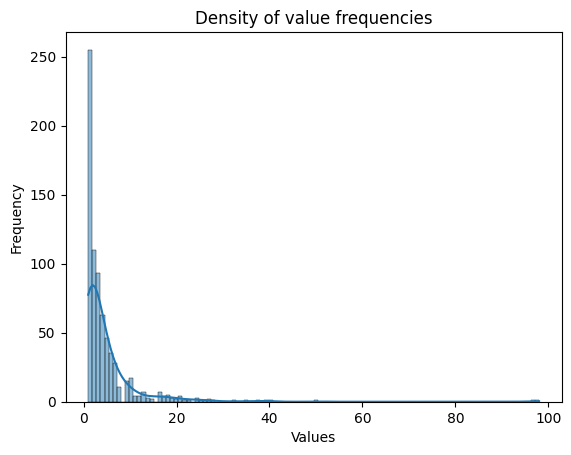

sellercity
Battle Creek    12.629819
Chicago         12.494528
Louisville       6.135870
Atlanta          4.782964
Richmond         4.647673
                  ...    
Florissant      -0.493370
Mansfield       -0.493370
Bridgeville     -0.493370
West Chicago    -0.493370
Vincennes       -0.493370
Name: count, Length: 736, dtype: float64


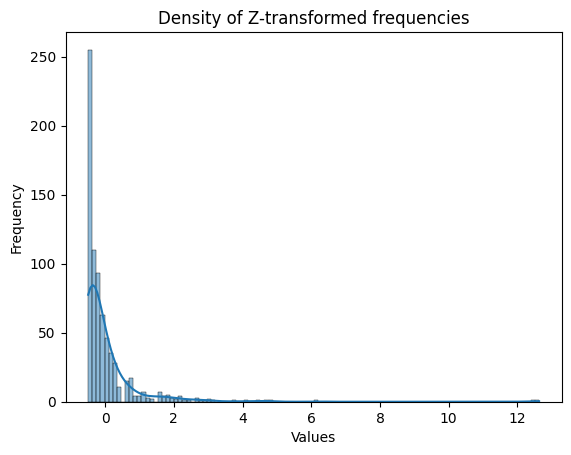

<Figure size 800x600 with 0 Axes>

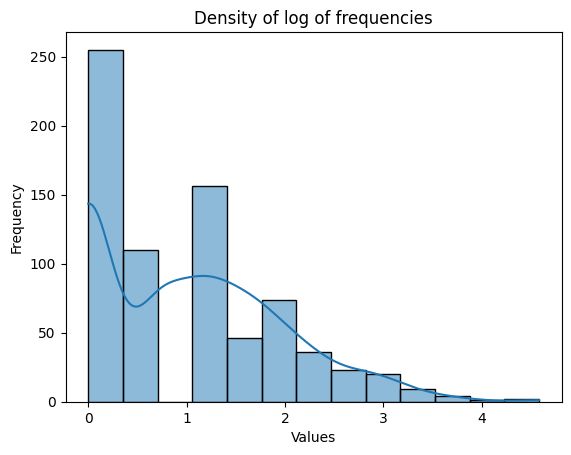

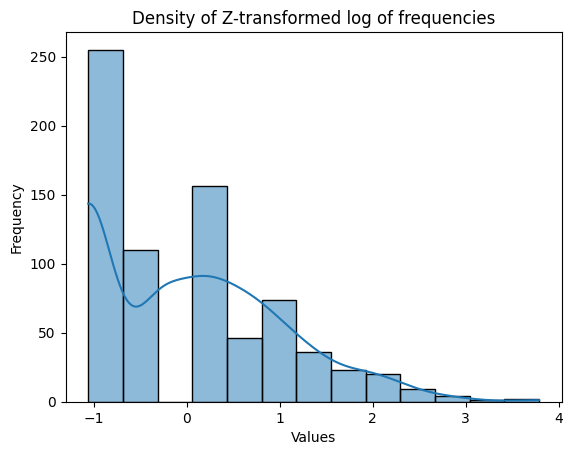

listingid
4777     17
6242      4
10882     2
12013     3
12334    25
Name: sellercity, dtype: int64

In [1671]:
value_counts = feat_ptrj.value_counts()
# Plotting a histogram of frequencies (Frequencies of Frequencies)
plotDist(value_counts,"Density of value frequencies")
#FREQUENCY ENCODE THESE VALUES AND THEN TAKE Z SCORE OR THE FREQUENCIES
zvalues = zScoreTransform(value_counts)
print(zvalues)
plotDist(zvalues,"Density of Z-transformed frequencies")
# Assuming 'value_counts' contains the frequencies
log_frequencies = np.log(value_counts)
# Plotting the density plot of the log of frequencies
plt.figure(figsize=(8, 6))
plotDist(log_frequencies,"Density of log of frequencies")
# Plotting the density plot of the log of frequencies
zlog = zScoreTransform(log_frequencies)
plotDist(zlog,"Density of Z-transformed log of frequencies")
freq = feat_ptrj.value_counts().to_dict()
feat_ptrj = feat_ptrj.map(freq)
feat_ptrj.head()

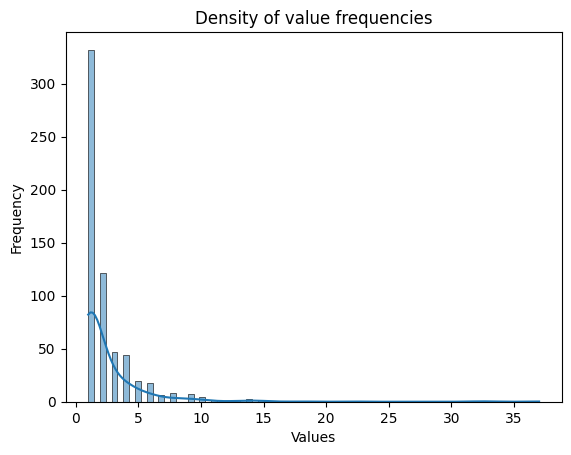

sellercity
Dallas         10.406809
Houston         9.199236
Palmyra         8.897343
Columbus        5.878410
Friendswood     4.670838
                 ...    
Sylvania       -0.461347
Alto           -0.461347
Riverdale      -0.461347
Cicero         -0.461347
Sandusky       -0.461347
Name: count, Length: 621, dtype: float64


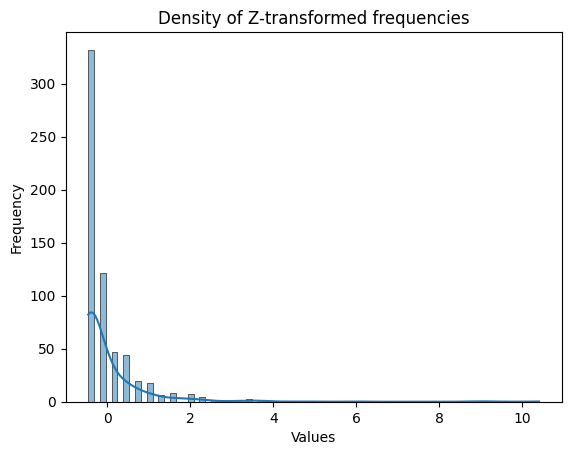

<Figure size 800x600 with 0 Axes>

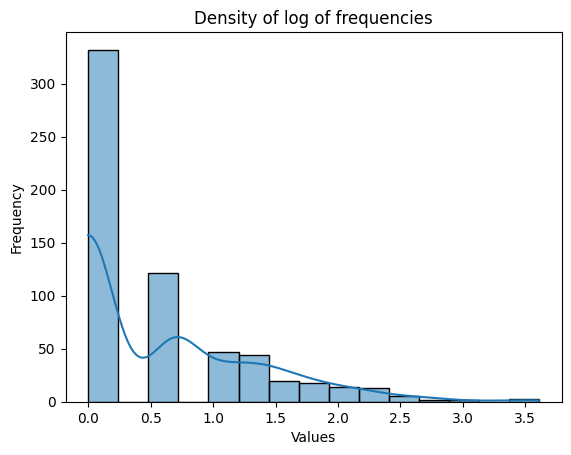

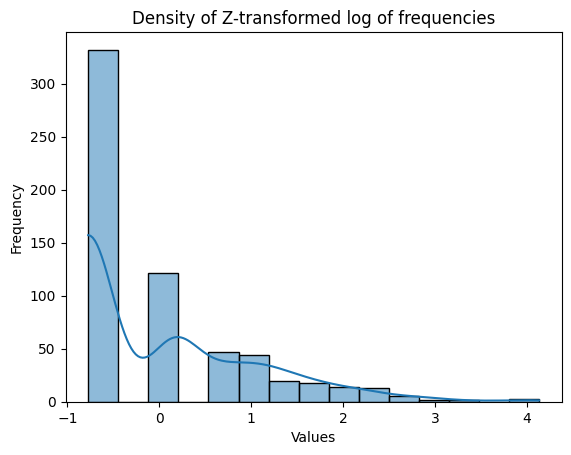

listingid
7108     2
21448    3
21807    4
30524    3
34061    2
Name: sellercity, dtype: int64

In [1672]:
value_counts = feat_ptrc.value_counts()
# Plotting a histogram of frequencies (Frequencies of Frequencies)
plotDist(value_counts,"Density of value frequencies")
#FREQUENCY ENCODE THESE VALUES AND THEN TAKE Z SCORE OR THE FREQUENCIES
zvalues = zScoreTransform(value_counts)
print(zvalues)
plotDist(zvalues,"Density of Z-transformed frequencies")
# Assuming 'value_counts' contains the frequencies
log_frequencies = np.log(value_counts)
# Plotting the density plot of the log of frequencies
plt.figure(figsize=(8, 6))
plotDist(log_frequencies,"Density of log of frequencies")
# Plotting the density plot of the log of frequencies
zlog = zScoreTransform(log_frequencies)
plotDist(zlog,"Density of Z-transformed log of frequencies")
freq = feat_ptrc.value_counts().to_dict()
feat_ptrc = feat_ptrc.map(freq)
feat_ptrc.head()

In [1673]:
input_jeeps[column] = feat_ptrj
input_jeeps.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehhistory,vehlistdays,vehmake,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear
listingid,,,,,,,,,,,,,,,,,,,,,
4777,17,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,True,...,"1 Owner, Buyback Protection Eligible",28.107014,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015
6242,4,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",59.816875,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018
10882,2,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",30.967500,Jeep,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018
12013,3,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,False,...,"1 Owner, Accident(s) Reported, Non-Personal Us...",194.482338,Jeep,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017
12334,25,False,Digital Motorworks (DMi),Larry Roesch Dodge Chrysler Jeep RAM,4.6,240,IL,60126.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",28.849537,Jeep,29095.0,Grand Cherokee,Great Deal,"BLIND SPOT/CROSS PATH DETECTION, APPLE CARPLAY...",Used,8-Speed Automatic,2018


In [1674]:
input_caddys[column] = feat_ptrc
input_caddys.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehhistory,vehlistdays,vehmake,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear
listingid,,,,,,,,,,,,,,,,,,,,,
7108,2,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",98.665301,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018
21448,3,False,HomeNet Automotive,Vroom (Online Dealer - Nationwide Delivery),3.7,629,LA,70130.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",5.682477,Cadillac,21098.0,XT5,Good Deal,"With Vroom, you can buy your next car from the...",Used,8-Speed Automatic,2018
21807,4,False,HomeNet Automotive,Sunset Cadillac of Bradenton,4.9,360,FL,34207.0,SUV,True,...,"1 Owner, Buyback Protection Eligible",6.737384,Cadillac,3547.0,XT5,Good Deal,"Recent Arrival! *CADILLAC CERTIFIED*, *CARFAX ...",Used,8-Speed Automatic,2019
30524,3,False,Digital Motorworks (DMi),CarMax Ft. Worth-Arlington,5.0,4,TX,76120.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",11.786840,Cadillac,12146.0,XT5,Good Deal,CarMax makes car buying easy and hassle-free. ...,Used,8-Speed Automatic,2017
34061,2,False,Digital Motorworks (DMi),Ron Craft Chevrolet Cadillac,4.3,312,TX,77521.0,SUV,False,...,"1 Owner, Non-Personal Use Reported, Buyback Pr...",25.899433,Cadillac,28293.0,XT5,Good Deal,Outstanding design defines the 2018 Cadillac X...,Used,8-Speed Automatic,2018


In [1675]:
freq_cols.append(column)
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrj)
print(feat_ptrc)

listingid
4777       False
6242       False
10882      False
12013      False
12334      False
           ...  
8610847    False
8612731    False
8614177    False
8615510    False
8620012    False
Name: sellerispriv, Length: 3420, dtype: bool
listingid
7108       False
21448      False
21807      False
30524      False
34061      False
           ...  
8599564    False
8601212    False
8604205    False
8616294    False
8617378    False
Name: sellerispriv, Length: 1570, dtype: bool


In [1676]:
print(feat_ptrj.value_counts())
print(feat_ptrc.value_counts())

sellerispriv
False    3420
Name: count, dtype: int64
sellerispriv
False    1570
Name: count, dtype: int64


In [1677]:
feats_to_drop.append(column)

col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.nunique())
print(feat_ptrj.unique())

feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.nunique())
print(feat_ptrc.unique())

5
['Jeep Certified Program' 'Inventory Command Center'
 'Digital Motorworks (DMi)' 'HomeNet Automotive' 'My Dealer Center']
4
['HomeNet Automotive' 'Digital Motorworks (DMi)'
 'Inventory Command Center' 'My Dealer Center']


In [1678]:
#A CATEGORY COLUMN EASY TO ONE HOT ENCODE WITH A SMALL ENUMERATION AMOUNT (ONLY REQUIRES
# 5 COLUMNS TO ENCODE)
encoded_cols.append(column)
print(feat_ptrj)
print(feat_ptrc)

col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

listingid
4777         Jeep Certified Program
6242       Inventory Command Center
10882      Digital Motorworks (DMi)
12013      Digital Motorworks (DMi)
12334      Digital Motorworks (DMi)
                     ...           
8610847          HomeNet Automotive
8612731      Jeep Certified Program
8614177    Digital Motorworks (DMi)
8615510    Digital Motorworks (DMi)
8620012          HomeNet Automotive
Name: sellerlistsrc, Length: 3420, dtype: object
listingid
7108             HomeNet Automotive
21448            HomeNet Automotive
21807            HomeNet Automotive
30524      Digital Motorworks (DMi)
34061      Digital Motorworks (DMi)
                     ...           
8599564    Digital Motorworks (DMi)
8601212    Digital Motorworks (DMi)
8604205          HomeNet Automotive
8616294    Digital Motorworks (DMi)
8617378    Digital Motorworks (DMi)
Name: sellerlistsrc, Length: 1570, dtype: object
listingid
4777        Wilde Chrysler Jeep Dodge Ram &amp; Subaru
6242                   Ce

In [1679]:
print(feat_ptrj.value_counts()[feat_ptrj.mode()]/len(feat_ptrj))
feat_ptrj.value_counts().head(30)

sellername
Carvana    0.069006
Name: count, dtype: float64


sellername
Carvana                                                    236
Vroom (Online Dealer - Nationwide Delivery)                183
Henkel Chrysler Dodge Jeep Ram                              98
Marino Chrysler Jeep Dodge RAM                              34
Barnett Chrysler Jeep Kia                                   33
Blue Knob Auto Sales                                        27
CarMax White Marsh                                          24
Larry Roesch Dodge Chrysler Jeep RAM                        23
Cross Chrysler Jeep Fiat                                    23
Park Chrysler Jeep                                          21
Sherman Dodge Chrysler Jeep RAM                             19
Westgate Chrysler Jeep Dodge RAM                            19
Woody&#x27;s Dodge Jeep Chrysler RAM                        18
Don White&#x27;s Timonium Chrysler Jeep Dodge and RAM       17
Hawk Chrysler Jeep Dodge RAM                                17
Mancari&#x27;s Chrysler Jeep Dodge Ram of Oa

In [1680]:
#NOT CATEGORICAL OR CONTAINS DOMINATE VALUES, WILL NOT SIGNFICANTLY IMPACT MODEL PREDICTION EFFICIENCY
feats_to_drop.append(column)

In [1681]:
col +=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

listingid
4777       4.8
6242       4.4
10882      3.0
12013      3.5
12334      4.6
          ... 
8610847    4.8
8612731    4.9
8614177    1.5
8615510    3.3
8620012    3.8
Name: sellerrating, Length: 3420, dtype: float64
listingid
7108       3.7
21448      3.7
21807      4.9
30524      5.0
34061      4.3
          ... 
8599564    4.4
8601212    4.8
8604205    4.7
8616294    4.1
8617378    4.9
Name: sellerrating, Length: 1570, dtype: float64


In [1682]:
#POSSIBLY NORMALIZE (Z-TRANSFORM) FOR NOW KEEP IT INTACT
same_cols.append(column)
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

listingid
4777       1405
6242         21
10882        51
12013        17
12334       240
           ... 
8610847    1016
8612731     121
8614177       6
8615510      16
8620012     727
Name: sellerrevcnt, Length: 3420, dtype: int64
listingid
7108        74
21448      629
21807      360
30524        4
34061      312
          ... 
8599564     15
8601212    461
8604205     58
8616294     20
8617378    278
Name: sellerrevcnt, Length: 1570, dtype: int64


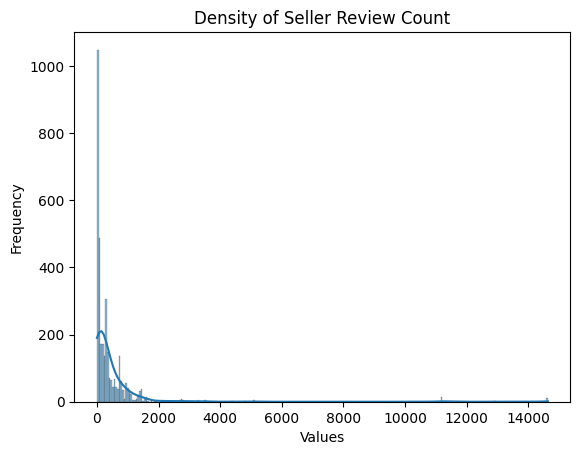

C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


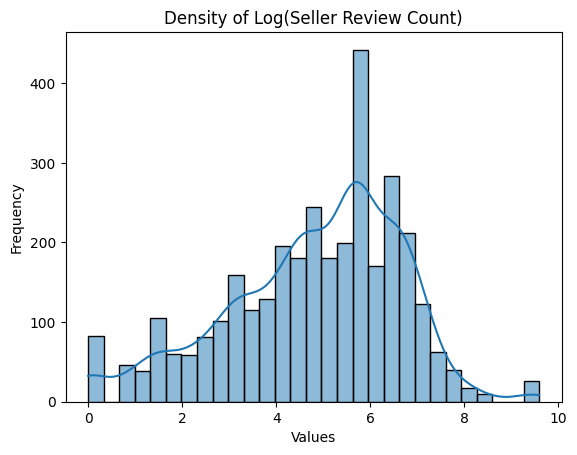

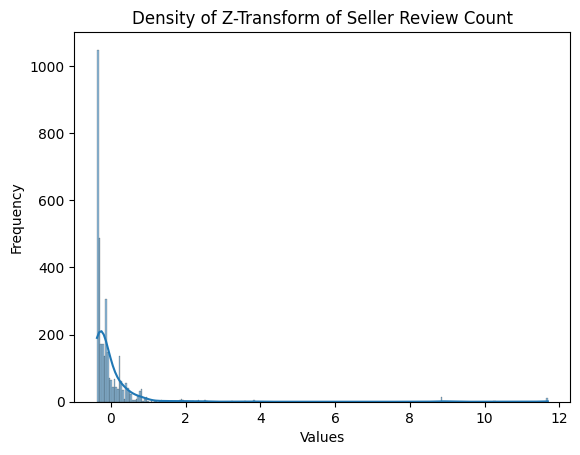

C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


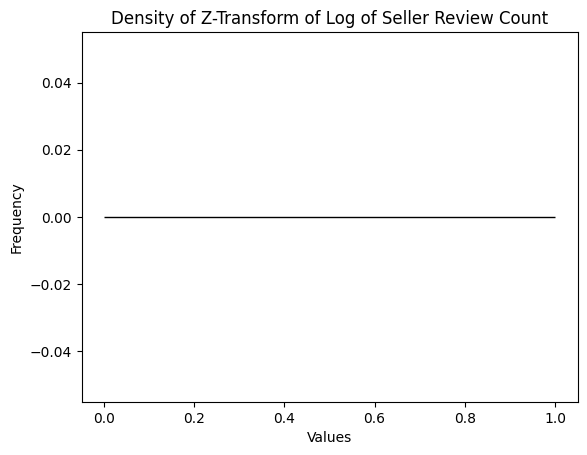

In [1683]:
plotDist(feat_ptrj,'Density of Seller Review Count')
plotDist(np.log(feat_ptrj),'Density of Log(Seller Review Count)')
plotDist(zScoreTransform(feat_ptrj),'Density of Z-Transform of Seller Review Count')
plotDist(zScoreTransform(np.log(feat_ptrj)),'Density of Z-Transform of Log of Seller Review Count')


In [1684]:
#KEEP REVIEW COUNT AS IS FOR NOW
same_cols.append(column)

col+=1 
feat_ptrj,column = setFeatPtr(input_jeeps,col)
feat_ptrj
feat_ptrc,column = setFeatPtr(input_caddys,col)
feat_ptrc

listingid
7108       AR
21448      LA
21807      FL
30524      TX
34061      TX
           ..
8599564    LA
8601212    VA
8604205    NY
8616294    OH
8617378    OH
Name: sellerstate, Length: 1570, dtype: object

In [1685]:
#STATES -> CATEGORICAL
encoded_cols.append(column)

col+=1 
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.nunique())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.nunique())

970
775


In [1686]:
#ZIP SEEMS REDUNDANT WITH CITY/STATE INFO ALREADY EXISTING
#PLUS THE AMOUNT OF VARYING ZIPS PROVIDES NOISY DATA
feats_to_drop.append(column)
print(feats_to_drop)

col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

['sellerispriv', 'sellername', 'sellerzip']
listingid
4777       SUV
6242       SUV
10882      SUV
12013      SUV
12334      SUV
          ... 
8610847    SUV
8612731    SUV
8614177    SUV
8615510    SUV
8620012    SUV
Name: vehbodystyle, Length: 3420, dtype: object
listingid
7108       SUV
21448      SUV
21807      SUV
30524      SUV
34061      SUV
          ... 
8599564    SUV
8601212    SUV
8604205    SUV
8616294    SUV
8617378    SUV
Name: vehbodystyle, Length: 1570, dtype: object


In [1687]:
print(feat_ptrj.nunique())
print(feat_ptrc.nunique())

1
1


In [1688]:
#ALL SUV, MEANINGLESS DATA
feats_to_drop.append(column)
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

listingid
4777        True
6242       False
10882      False
12013      False
12334      False
           ...  
8610847    False
8612731     True
8614177    False
8615510    False
8620012    False
Name: vehcertified, Length: 3420, dtype: bool
listingid
7108       False
21448      False
21807       True
30524      False
34061      False
           ...  
8599564     True
8601212    False
8604205     True
8616294     True
8617378    False
Name: vehcertified, Length: 1570, dtype: bool


In [1689]:
#MASK BOOLEANS AS 1 AND 0's
feat_ptrj = (feat_ptrj).astype(int)
input_jeeps[column] = feat_ptrj
feat_ptrc = (feat_ptrc).astype(int)
input_caddys[column] = feat_ptrc
mask_cols.append(column)

col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

listingid
4777       Brilliant Black Crystal Pearlcoat
6242         Diamond Black Crystal Pearlcoat
10882       Billet Silver Metallic Clearcoat
12013                    True Blue Pearlcoat
12334                                    Red
                         ...                
8610847      Walnut Brown Metallic Clearcoat
8612731    Brilliant Black Crystal Pearlcoat
8614177                                Black
8615510                                 Gray
8620012      Diamond Black Crystal Pearlcoat
Name: vehcolorext, Length: 3420, dtype: object
listingid
7108       Radiant Silver Metallic
21448        Dark Granite Metallic
21807        Crystal White Tricoat
30524                        White
34061        Dark Granite Metallic
                    ...           
8599564     Stellar Black Metallic
8601212                      White
8604205     Stellar Black Metallic
8616294                      Black
8617378                      Black
Name: vehcolorext, Length: 1570, dtype: object


In [1690]:
print(feat_ptrj.value_counts())
print(feat_ptrc.value_counts())

vehcolorext
Bright White Clearcoat                 529
Brilliant Black Crystal Pearlcoat      336
Billet Silver Metallic Clearcoat       336
Granite Crystal Metallic Clearcoat     215
Diamond Black                          189
                                      ... 
True Blue Pearl                          1
Diamond Black Crystal                    1
Certified Lthr Pano Roof Nav Camera      1
Db Black                                 1
Bright Sil                               1
Name: count, Length: 106, dtype: int64
vehcolorext
Stellar Black Metallic         289
Radiant Silver Metallic        245
Dark Granite Metallic          193
Crystal White Tricoat          117
Crystal White Tri-Coat          96
Red Passion Tintcoat            88
Black                           61
Black Metallic                  59
Silver                          56
Crystal White                   50
Red                             36
Silver Coast Metallic           34
Dark Adriatic Blue Metallic     33
Bronze Du

In [1691]:
temp_dfj = handle_vehcolorext(feat_ptrj)
temp_dfj.columns = temp_dfj.columns.str.lower()
temp_dfc = handle_vehcolorext(feat_ptrc)
temp_dfc.columns = temp_dfc.columns.str.lower()

#Encoded with hand-written function rather than the encoder
self_encodej = pd.DataFrame(temp_dfj, index=temp_dfj.index,columns=temp_dfj.columns)
self_encodec = pd.DataFrame(temp_dfc, index=temp_dfc.index,columns=temp_dfc.columns)

orig_cols.append(column)
#Want to drop original
feats_to_drop.append(column)

print(temp_dfj.sum())
print(temp_dfj[temp_dfj["none"]==1].index)

print(temp_dfc.sum())
print(temp_dfc[temp_dfc["none"]==1].index)

COLOR
COLOR
black         827
blue          160
brown          52
green          14
metallic      868
pearlcoat     818
clearcoat    1338
granite       439
red           407
silver        679
white         719
none           93
dtype: int64
Index([ 287172,  528899,  792826,  822663,  827114,  860178,  989049,  993403,
       1006148, 1134881, 1311053, 1433145, 1468297, 1594834, 1782190, 1863438,
       1886831, 1920561, 1976588, 2639728, 2647801, 2834957, 2852632, 2968937,
       2986112, 3251931, 3259360, 3318075, 3323591, 3512146, 3576115, 3768077,
       3825286, 3834986, 3866247, 3891373, 3967275, 4039043, 4518085, 4545377,
       4651188, 4718768, 5021539, 5055233, 5111906, 5375784, 5535172, 5545542,
       5578181, 5587030, 5631096, 5644968, 5708516, 5992176, 6162356, 6246694,
       6273905, 6515958, 6523263, 6577912, 6585299, 6606369, 6651125, 6656294,
       6675697, 6725167, 6832160, 6908201, 6958924, 6996435, 7089792, 7187171,
       7255713, 7274472, 7307601, 7395341, 74236

In [1692]:
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehcolorint
Black                        2620
Black Leather                  95
black                          87
Light Frost                    83
Brown                          54
                             ... 
Black / Light Frost Beige       1
CHARCOAL                        1
Ruby Red/Black Leather          1
Black/Ruby Red                  1
Black, cloth                    1
Name: count, Length: 65, dtype: int64
vehcolorint
Jet Black                                             747
Shara Beige                                           236
Sahara Beige                                          143
Cirrus                                                131
Black                                                  89
Maple Sugar                                            67
Tan                                                    38
jet black                                              29
Carbon Plum                                            15
sahara beige                              

In [1693]:
temp_dfj = handle_vehcolorint(feat_ptrj)
temp_dfj.columns = temp_dfj.columns.str.lower()
temp_dfc = handle_vehcolorint(feat_ptrc)
temp_dfc.columns = temp_dfc.columns.str.lower()

#Merge two handwritten encoded columns
self_encodej = pd.merge(self_encodej, temp_dfj, left_index=True,right_index=True)
self_encodec = pd.merge(self_encodec, temp_dfc, left_index=True,right_index=True)

orig_cols.append(column)
#Want to drop original
feats_to_drop.append(column)

print(temp_dfj.sum())
print(temp_dfj[temp_dfj["none"]==1].index)

print(temp_dfc.sum())
print(temp_dfc[temp_dfc["none"]==1].index)

COLOR2
COLOR2
black     3050
blue        18
brown      168
beige      148
trim         0
red        110
silver      39
frost      282
maple        0
tan         16
cirrus       0
carbon       0
plum         0
none        13
dtype: int64
Index([ 903203, 1491106, 2000241, 2028388, 2102637, 2585204, 3198504, 3409549,
       4761924, 5102938, 5252166, 6400857, 6475088],
      dtype='int64', name='listingid')
black     899
blue        0
brown       0
beige     409
trim       11
red         0
silver      2
frost       0
maple      68
tan        42
cirrus    136
carbon     17
plum       15
none       10
dtype: int64
Index([2729520, 2839309, 2842810, 4833074, 4904298, 5013738, 5538849, 6022159,
       7504666, 8084993],
      dtype='int64', name='listingid')


In [1694]:
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

listingid
4777       4x4/4WD
6242           4WD
10882          4WD
12013          4WD
12334          4WD
            ...   
8610847        4WD
8612731        4WD
8614177        4WD
8615510        4WD
8620012        4WD
Name: vehdrivetrain, Length: 3420, dtype: object
listingid
7108       FWD
21448      FWD
21807      FWD
30524      FWD
34061      FWD
          ... 
8599564    FWD
8601212    FWD
8604205    AWD
8616294    FWD
8617378    FWD
Name: vehdrivetrain, Length: 1570, dtype: object


In [1695]:
print(feat_ptrj.value_counts())
print(feat_ptrc.value_counts())

vehdrivetrain
4WD                 3335
4X4                   32
Four Wheel Drive      29
4x4/4WD                9
4x4                    6
AWD or 4x4             5
AWD                    3
4WD/AWD                1
Name: count, dtype: int64
vehdrivetrain
FWD                                                           903
AWD                                                           627
All Wheel Drive                                                18
Front Wheel Drive                                              16
All-wheel Drive                                                 3
ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL      1
ALL WHEEL                                                       1
AllWheelDrive                                                   1
Name: count, dtype: int64


In [1696]:
#BASED OFF UNIQUE VALUES SEPERATE INTO 4WD,FWD,or AWD
temp_dfj = handle_vehdrivetrain(feat_ptrj)
print(temp_dfj.value_counts())
temp_dfc = handle_vehdrivetrain(feat_ptrc)
print(temp_dfc.value_counts())

vehdrivetrain
_4_wd     3411
hybrid       6
awd          3
Name: count, dtype: int64
vehdrivetrain
fwd    919
awd    651
Name: count, dtype: int64


In [1697]:
input_jeeps[column] = temp_dfj
input_caddys[column] = temp_dfc
encoded_cols.append(column)
orig_cols.append(column)
col+=1
print(encoded_cols)
print(input_jeeps[column])
print(input_caddys[column])

['sellerlistsrc', 'sellerstate', 'vehdrivetrain']
listingid
4777       _4_wd
6242       _4_wd
10882      _4_wd
12013      _4_wd
12334      _4_wd
           ...  
8610847    _4_wd
8612731    _4_wd
8614177    _4_wd
8615510    _4_wd
8620012    _4_wd
Name: vehdrivetrain, Length: 3420, dtype: object
listingid
7108       fwd
21448      fwd
21807      fwd
30524      fwd
34061      fwd
          ... 
8599564    fwd
8601212    fwd
8604205    awd
8616294    fwd
8617378    fwd
Name: vehdrivetrain, Length: 1570, dtype: object


In [1698]:
feat_ptrj,column = setFeatPtr(input_jeeps,col)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrj.value_counts())
print(feat_ptrc.value_counts())

vehengine
3.6L V6 24V MPFI DOHC                  1566
Regular Unleaded V-6 3.6 L/220          552
3.6L V6 24V MPFI DOHC Flexible Fuel     301
3.6L V6 24V VVT                         254
3.6L V6                                 169
                                       ... 
6.4L HEMI V8                              1
3.0L V6                                   1
5.7L V8 OHV 16V                           1
V6 3.6L Natural Aspiration                1
6.2L 8 Cyl.                               1
Name: count, Length: 66, dtype: int64
vehengine
3.6L V6 24V GDI DOHC                                920
Gas V6 3.6L/222.6                                   317
3.6L V6 DI VVT                                      133
6 Cylinder                                           51
3.6L                                                 28
V6 Cylinder Engine 3.6L                              25
3.6L V6 CYLINDER                                     18
3.6L V6                                              18
Gas V6 3.6

In [1699]:
#handle_vehengine takes the vehEngine column and turns it into a 
#2 column data frame by splitting the phrases into engine size 
#and cyclinder configuration
temp_dfj = handle_vehengine(feat_ptrj)
temp_dfc = handle_vehengine(feat_ptrc)

print(temp_dfj["EngineSize"].value_counts())
print(temp_dfj["Cylinders"].value_counts())
print(temp_dfc["EngineSize"].value_counts())
print(temp_dfc["Cylinders"].value_counts())

# '0' represents unknown for either columns

EngineSize
3.6    3021
5.7     198
0.0      78
6.4      63
3.0      37
6.2      23
Name: count, dtype: int64
Cylinders
6    3063
8     279
0      78
Name: count, dtype: int64
EngineSize
3.6    1503
0.0      67
Name: count, dtype: int64
Cylinders
6    1535
0      35
Name: count, dtype: int64


In [1700]:
input_jeeps[temp_dfj.columns] = temp_dfj
input_caddys[temp_dfc.columns] = temp_dfc

orig_cols.append(column)
feats_to_drop.append(column)

col+=1
print(encoded_cols)
print(temp_dfj)
print(temp_dfc)

['sellerlistsrc', 'sellerstate', 'vehdrivetrain']
           EngineSize  Cylinders
listingid                       
4777              3.6          6
6242              3.6          6
10882             3.6          6
12013             3.6          6
12334             3.6          6
...               ...        ...
8610847           3.6          6
8612731           3.6          6
8614177           3.6          6
8615510           3.0          6
8620012           3.6          6

[3420 rows x 2 columns]
           EngineSize  Cylinders
listingid                       
7108              3.6          6
21448             3.6          6
21807             3.6          6
30524             3.6          6
34061             3.6          6
...               ...        ...
8599564           3.6          6
8601212           3.6          6
8604205           3.6          6
8616294           3.6          6
8617378           3.6          6

[1570 rows x 2 columns]


In [1701]:
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

listingid
4777       ['18 WHEEL &amp; 8.4 RADIO GROUP-inc: Nav-Capa...
6242       ['Android Auto', 'Antilock Brakes', 'Apple Car...
10882      ['1st and 2nd row curtain head airbags', '4-wh...
12013      ['1st and 2nd row curtain head airbags', '4-wh...
12334      ['1st and 2nd row curtain head airbags', '4-wh...
                                 ...                        
8610847    ['3.45 REAR AXLE RATIO(STD)', '4-Wheel Disc Br...
8612731    ['1st and 2nd row curtain head airbags', '4-wh...
8614177    ['1st and 2nd row curtain head airbags', '4-wh...
8615510    ['1st and 2nd row curtain head airbags', '4-wh...
8620012    ['Airbag Occupancy Sensor', 'Curtain 1st And 2...
Name: vehfeats, Length: 3420, dtype: object
listingid
7108       ['4-Wheel Disc Brakes', 'ABS', 'Adjustable Ste...
21448      ['20 Inch Alloy Wheels', '3.6L V6 Engine', 'An...
21807      ['ABS', 'Aluminum Wheels', 'AUDIO SYSTEM FEATU...
30524      ['1st and 2nd row curtain head airbags', '4-wh...
34061      ['1st and 

In [1702]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
tf_featsj = TfidfVectorizer(max_df=0.50,max_features=30)
temp_dfj = feat_ptrj.copy()
tf_featsj = tf_featsj.fit(temp_dfj)
vocab1j = tf_idfTokenizer(temp_dfj,tf_featsj)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
vocab1j.head()

,air,alarm,alloy,aluminum,am,anti,antilock,auto,automatic,auxiliary,...,front,input,memory,prep,radio,satellite,seats,slot,theft,wheels
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.000000,0.000000,0.0,0.362589,0.260283,0.000000,0.000000,0.359060,0.261243,0.329415,...,0.000000,0.329967,0.000000,0.000000,0.315851,0.000000,0.000000,0.000000,0.000000,0.285887
6242,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.397475,0.426209,0.000000,0.391020,...,0.000000,0.391675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10882,0.000000,0.303521,0.0,0.000000,0.000000,0.292306,0.000000,0.000000,0.000000,0.000000,...,0.312558,0.000000,0.000000,0.000000,0.000000,0.000000,0.417777,0.000000,0.304312,0.000000
12013,0.289613,0.000000,0.0,0.000000,0.256202,0.000000,0.000000,0.000000,0.257148,0.000000,...,0.238747,0.000000,0.215867,0.336585,0.310900,0.334803,0.000000,0.225877,0.000000,0.000000
12334,0.000000,0.303521,0.0,0.000000,0.000000,0.292306,0.000000,0.000000,0.000000,0.000000,...,0.312558,0.000000,0.000000,0.000000,0.000000,0.000000,0.417777,0.000000,0.304312,0.000000


In [1703]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
tf_featsc = TfidfVectorizer(max_df=0.50,max_features=30)
temp_dfc = feat_ptrc.copy()
tf_featsc = tf_featsc.fit(temp_dfc)
vocab1c = tf_idfTokenizer(temp_dfc,tf_featsc)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
vocab1c.head()

,all,aluminum,android,apple,assist,auto,automatic,auxiliary,beverage,blind,...,in,input,phone,security,spot,studio,surround,trim,wheels,wireless
listingid,,,,,,,,,,,,,,,,,,,,,
7108,0.0,0.273007,0.000000,0.000000,0.000000,0.305368,0.318800,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.310766,0.609067,0.00000,0.333605,0.000000
21448,0.0,0.000000,0.308276,0.315974,0.000000,0.274410,0.572961,0.325261,0.000000,0.0,...,0.000000,0.325632,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.299784,0.000000
21807,0.0,0.169650,0.213179,0.218502,0.186359,0.189760,0.198107,0.449849,0.000000,0.0,...,0.000000,0.450361,0.000000,0.000000,0.0,0.193114,0.378483,0.00000,0.207307,0.000000
30524,0.0,0.000000,0.000000,0.000000,0.332808,0.000000,0.353788,0.000000,0.000000,0.0,...,0.000000,0.000000,0.356182,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.365037
34061,0.0,0.279240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317566,0.0,...,0.316388,0.000000,0.000000,0.314062,0.0,0.317862,0.311487,0.33712,0.000000,0.000000


In [1704]:
#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
tokenize_cols = [column]
input_jeeps.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehmake,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear,EngineSize,Cylinders
listingid,,,,,,,,,,,,,,,,,,,,,
4777,17,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,1,...,Jeep,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,3.6,6
6242,4,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,0,...,Jeep,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,3.6,6
10882,2,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,0,...,Jeep,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018,3.6,6
12013,3,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,0,...,Jeep,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017,3.6,6
12334,25,False,Digital Motorworks (DMi),Larry Roesch Dodge Chrysler Jeep RAM,4.6,240,IL,60126.0,SUV,0,...,Jeep,29095.0,Grand Cherokee,Great Deal,"BLIND SPOT/CROSS PATH DETECTION, APPLE CARPLAY...",Used,8-Speed Automatic,2018,3.6,6


In [1705]:
input_caddys.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehmake,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear,EngineSize,Cylinders
listingid,,,,,,,,,,,,,,,,,,,,,
7108,2,False,HomeNet Automotive,Superior Buick GMC of Fayetteville,3.7,74,AR,72703.0,SUV,0,...,Cadillac,19788.0,XT5,Good Deal,"Luxury, Exterior Parking Camera Rear, Front Du...",Used,8-Speed Automatic,2018,3.6,6
21448,3,False,HomeNet Automotive,Vroom (Online Dealer - Nationwide Delivery),3.7,629,LA,70130.0,SUV,0,...,Cadillac,21098.0,XT5,Good Deal,"With Vroom, you can buy your next car from the...",Used,8-Speed Automatic,2018,3.6,6
21807,4,False,HomeNet Automotive,Sunset Cadillac of Bradenton,4.9,360,FL,34207.0,SUV,1,...,Cadillac,3547.0,XT5,Good Deal,"Recent Arrival! *CADILLAC CERTIFIED*, *CARFAX ...",Used,8-Speed Automatic,2019,3.6,6
30524,3,False,Digital Motorworks (DMi),CarMax Ft. Worth-Arlington,5.0,4,TX,76120.0,SUV,0,...,Cadillac,12146.0,XT5,Good Deal,CarMax makes car buying easy and hassle-free. ...,Used,8-Speed Automatic,2017,3.6,6
34061,2,False,Digital Motorworks (DMi),Ron Craft Chevrolet Cadillac,4.3,312,TX,77521.0,SUV,0,...,Cadillac,28293.0,XT5,Good Deal,Outstanding design defines the 2018 Cadillac X...,Used,8-Speed Automatic,2018,3.6,6


In [1706]:
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehfuel
Gasoline         3070
E85 Flex Fuel     310
Diesel             35
Unknown             5
Name: count, dtype: int64
vehfuel
Gasoline    1570
Name: count, dtype: int64


In [1707]:
encoded_cols.append(column)

col+=1

In [1708]:
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj)
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc)

temp_dfj = feat_ptrj.str.split(',',n=1,expand=True)
temp_dfj.columns = ['Owners', 'History']
temp_dfj["History"].unique()

listingid
4777                    1 Owner, Buyback Protection Eligible
6242       1 Owner, Non-Personal Use Reported, Buyback Pr...
10882      1 Owner, Non-Personal Use Reported, Buyback Pr...
12013      1 Owner, Accident(s) Reported, Non-Personal Us...
12334      1 Owner, Non-Personal Use Reported, Buyback Pr...
                                 ...                        
8610847                 1 Owner, Buyback Protection Eligible
8612731                 1 Owner, Buyback Protection Eligible
8614177                 1 Owner, Buyback Protection Eligible
8615510    1 Owner, Accident(s) Reported, Non-Personal Us...
8620012    1 Owner, Non-Personal Use Reported, Buyback Pr...
Name: vehhistory, Length: 3420, dtype: object
listingid
7108       1 Owner, Non-Personal Use Reported, Buyback Pr...
21448      1 Owner, Non-Personal Use Reported, Buyback Pr...
21807                   1 Owner, Buyback Protection Eligible
30524      1 Owner, Non-Personal Use Reported, Buyback Pr...
34061      1 Owner,

array([' Buyback Protection Eligible',
       ' Non-Personal Use Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Buyback Protection Eligible',
       ' Title Issue(s) Reported',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported',
       ' Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Title Issue(s) Reported',
       ' Accident(s) Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       None], dtype=object)

In [1709]:
temp_dfc = feat_ptrc.str.split(',',n=1,expand=True)
temp_dfc.columns = ['Owners', 'History']
temp_dfc["History"].unique()

array([' Non-Personal Use Reported, Buyback Protection Eligible',
       ' Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported',
       ' Accident(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Title Issue(s) Reported',
       ' Title Issue(s) Reported',
       ' Non-Personal Use Reported, Title Issue(s) Reported',
       ' Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible',
       ' Accident(s) Reported, Title Issue(s) Reported, Buyback Protection Eligible'],
      dtype=object)

In [1710]:
temp_dfj['Owners'] = temp_dfj['Owners'].str.extract(r'^(\d+)')
temp_dfc['Owners'] = temp_dfc['Owners'].str.extract(r'^(\d+)')

temp_dfj['Owners'].head()

listingid
4777     1
6242     1
10882    1
12013    1
12334    1
Name: Owners, dtype: object

In [1711]:
input_jeeps['Owners'] = temp_dfj['Owners']
input_caddys['Owners'] = temp_dfc['Owners']

print(input_jeeps['Owners'])
print(input_caddys['Owners'])

listingid
4777       1
6242       1
10882      1
12013      1
12334      1
          ..
8610847    1
8612731    1
8614177    1
8615510    1
8620012    1
Name: Owners, Length: 3420, dtype: object
listingid
7108       1
21448      1
21807      1
30524      1
34061      1
          ..
8599564    1
8601212    1
8604205    1
8616294    0
8617378    2
Name: Owners, Length: 1570, dtype: object


In [1712]:
temp_dfj["History"].value_counts()

History
 Buyback Protection Eligible                                                                              1901
 Non-Personal Use Reported, Buyback Protection Eligible                                                   1116
 Accident(s) Reported, Buyback Protection Eligible                                                         196
 Accident(s) Reported, Non-Personal Use Reported, Buyback Protection Eligible                              117
 Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported                                   43
 Title Issue(s) Reported                                                                                    20
 Accident(s) Reported, Title Issue(s) Reported, Buyback Protection Eligible                                  5
 Accident(s) Reported, Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible       4
 Non-Personal Use Reported, Title Issue(s) Reported, Buyback Protection Eligible                        

In [1713]:
#TURNS OUT THAT THESE PHRASES CAN ACTUALLY BE TURNED INTO CATEGORICAL COLUMNS
#EACH ELEMENT IS A COMBINATION OF VARYING SIZE OF THE 4 POSSIBLE UNIQUE PHRASES
#ONE HOT ENCODE WITH A COLUMN FOR EACH PHRASE
encoded_histj = handle_vehhistory(temp_dfj["History"])
encoded_histj.head()

HISTORY


,Accident(s) Reported,Buyback Protection Eligible,Non-Personal Use Reported,Title Issue(s) Reported,None of the above
listingid,,,,,
4777,0,1,0,0,0
6242,0,0,1,0,0
10882,0,0,1,0,0
12013,1,0,0,0,0
12334,0,0,1,0,0


In [1714]:
encoded_histc = handle_vehhistory(temp_dfc["History"])
encoded_histc.head()

HISTORY


,Accident(s) Reported,Buyback Protection Eligible,Non-Personal Use Reported,Title Issue(s) Reported,None of the above
listingid,,,,,
7108,0,0,1,0,0
21448,0,0,1,0,0
21807,0,1,0,0,0
30524,0,0,1,0,0
34061,0,0,1,0,0


In [1715]:
#DROP ORIGINAL COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
self_encodej = pd.merge(self_encodej, encoded_histj, left_index=True, right_index=True)
self_encodec = pd.merge(self_encodec, encoded_histc, left_index=True, right_index=True)

orig_cols.append(column)
self_encodej.head()

,black_x,blue_x,brown_x,green,metallic,pearlcoat,clearcoat,granite,red_x,silver_x,...,tan,cirrus,carbon,plum,none_y,Accident(s) Reported,Buyback Protection Eligible,Non-Personal Use Reported,Title Issue(s) Reported,None of the above
listingid,,,,,,,,,,,,,,,,,,,,,
4777,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6242,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10882,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
12013,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12334,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [1716]:
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())
feat_ptrj.head()

vehlistdays
95.771331     12
6.913530       6
95.771343      5
106.541817     5
109.752431     5
              ..
145.458866     1
7.672801       1
202.458657     1
26.955544      1
20.678600      1
Name: count, Length: 3243, dtype: int64
vehlistdays
42.228171     6
11.784618     6
29.929606     5
11.093495     5
3.422338      4
             ..
12.586238     1
146.129201    1
265.647998    1
4.786713      1
73.868426     1
Name: count, Length: 1501, dtype: int64


listingid
4777      28.107014
6242      59.816875
10882     30.967500
12013    194.482338
12334     28.849537
Name: vehlistdays, dtype: float64

In [1717]:
#Use ceiling in order to round to whole days and start the listings 
#on day 1 rather than day 0
feat_ptrj = pd.Series(np.ceil(feat_ptrj),index=feat_ptrj.index)
feat_ptrc = pd.Series(np.ceil(feat_ptrc),index=feat_ptrc.index)

feat_ptrj.head()

listingid
4777      29.0
6242      60.0
10882     31.0
12013    195.0
12334     29.0
Name: vehlistdays, dtype: float64

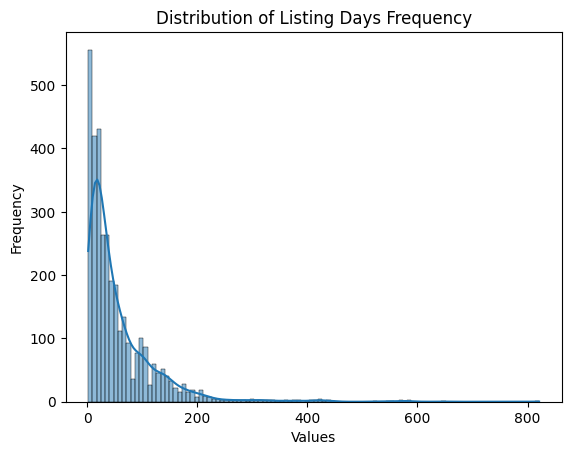

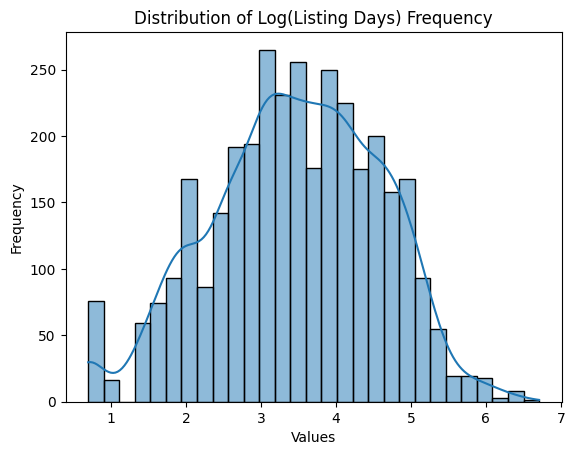

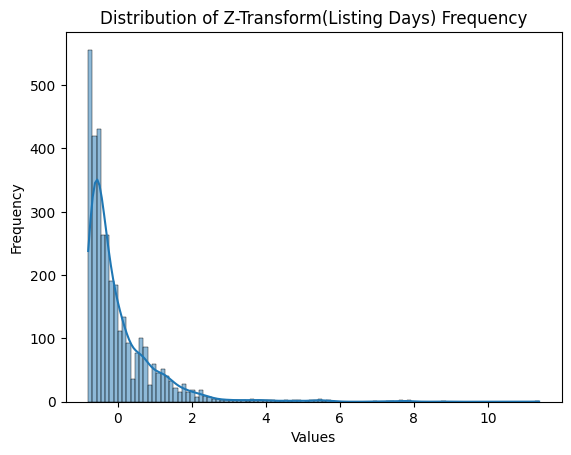

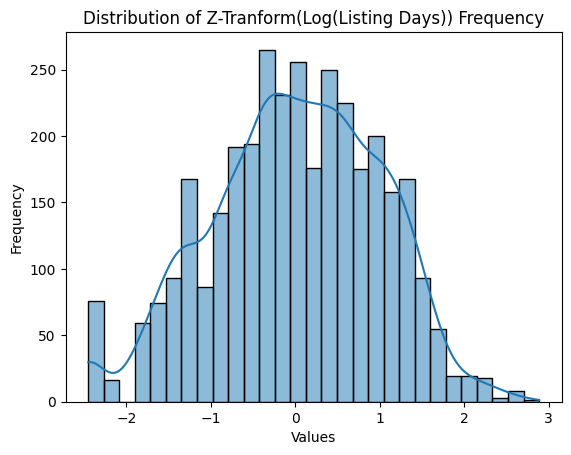

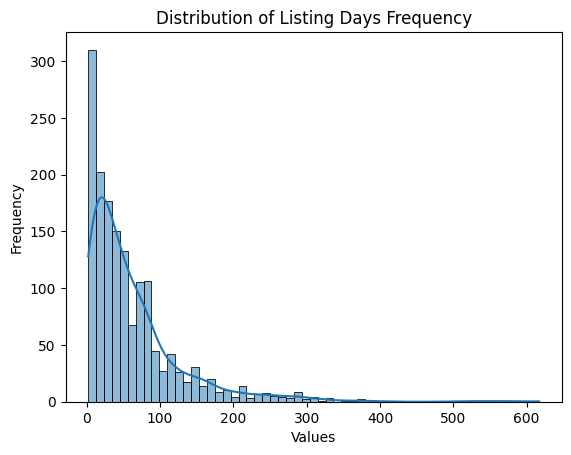

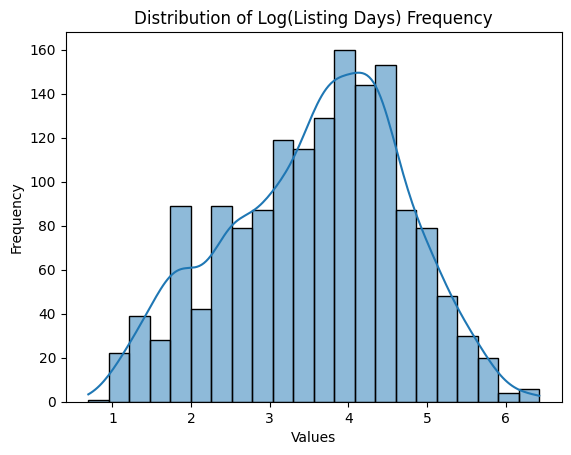

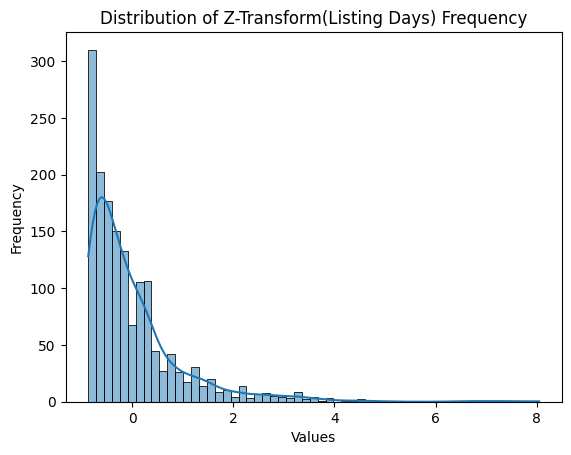

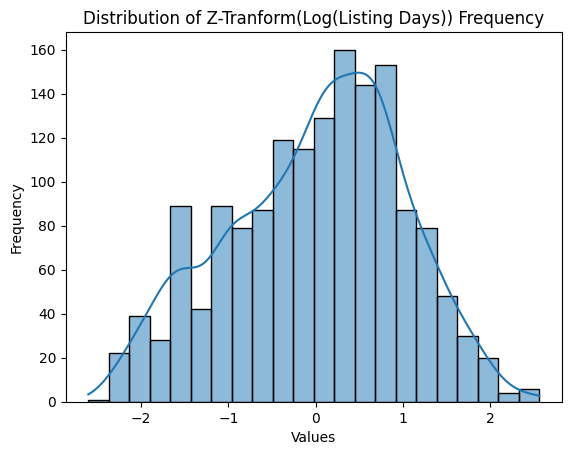

In [1718]:
plotDist(feat_ptrj,"Distribution of Listing Days Frequency")
plotDist(np.log(feat_ptrj),"Distribution of Log(Listing Days) Frequency")
plotDist(zScoreTransform(feat_ptrj),"Distribution of Z-Transform(Listing Days) Frequency")
plotDist(zScoreTransform(np.log(feat_ptrj)),"Distribution of Z-Tranform(Log(Listing Days)) Frequency")

plotDist(feat_ptrc,"Distribution of Listing Days Frequency")
plotDist(np.log(feat_ptrc),"Distribution of Log(Listing Days) Frequency")
plotDist(zScoreTransform(feat_ptrc),"Distribution of Z-Transform(Listing Days) Frequency")
plotDist(zScoreTransform(np.log(feat_ptrc)),"Distribution of Z-Tranform(Log(Listing Days)) Frequency")


In [1719]:
#CHOOSE LOG VALUE
#feat_ptrj = np.log(feat_ptrj)
#feat_ptrc = np.log(feat_ptrc)

print(feat_ptrj)
print(feat_ptrc)

listingid
4777        29.0
6242        60.0
10882       31.0
12013      195.0
12334       29.0
           ...  
8610847    103.0
8612731     39.0
8614177     40.0
8615510      5.0
8620012     21.0
Name: vehlistdays, Length: 3420, dtype: float64
listingid
7108        99.0
21448        6.0
21807        7.0
30524       12.0
34061       26.0
           ...  
8599564     35.0
8601212     19.0
8604205     20.0
8616294    185.0
8617378     74.0
Name: vehlistdays, Length: 1570, dtype: float64


In [1720]:
input_jeeps[column] = feat_ptrj
input_caddys[column] = feat_ptrc
log_cols.append(column)

col+=1
input_jeeps.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear,EngineSize,Cylinders,Owners
listingid,,,,,,,,,,,,,,,,,,,,,
4777,17,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,1,...,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,3.6,6,1
6242,4,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,0,...,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,3.6,6,1
10882,2,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,0,...,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018,3.6,6,1
12013,3,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,0,...,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017,3.6,6,1
12334,25,False,Digital Motorworks (DMi),Larry Roesch Dodge Chrysler Jeep RAM,4.6,240,IL,60126.0,SUV,0,...,29095.0,Grand Cherokee,Great Deal,"BLIND SPOT/CROSS PATH DETECTION, APPLE CARPLAY...",Used,8-Speed Automatic,2018,3.6,6,1


In [1721]:
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())
feat_ptrj.head()

vehmake
Jeep    3420
Name: count, dtype: int64
vehmake
Cadillac    1570
Name: count, dtype: int64


listingid
4777     Jeep
6242     Jeep
10882    Jeep
12013    Jeep
12334    Jeep
Name: vehmake, dtype: object

In [1722]:
#The defining attribute of each list, going to keep the same for now in case the handler functions become "make" specific
same_cols.append(column)

col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehmileage
40277.0    24
37151.0    20
36334.0    17
20207.0    12
40592.0    12
           ..
26449.0     1
41859.0     1
31281.0     1
17332.0     1
20039.0     1
Name: count, Length: 2940, dtype: int64
vehmileage
17536.0    27
26181.0    24
21098.0    23
5343.0     22
11310.0    21
           ..
24553.0     1
13727.0     1
10774.0     1
17201.0     1
38146.0     1
Name: count, Length: 1395, dtype: int64


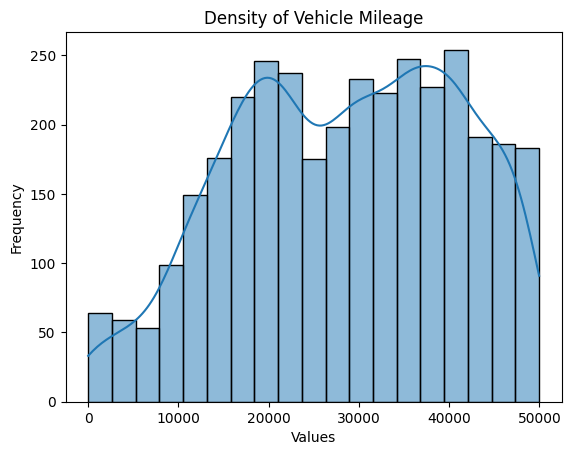

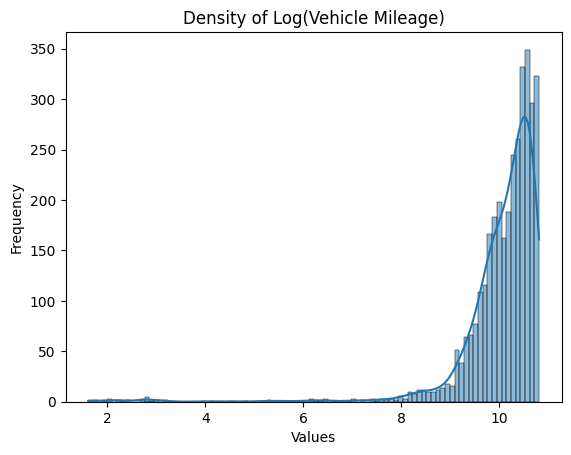

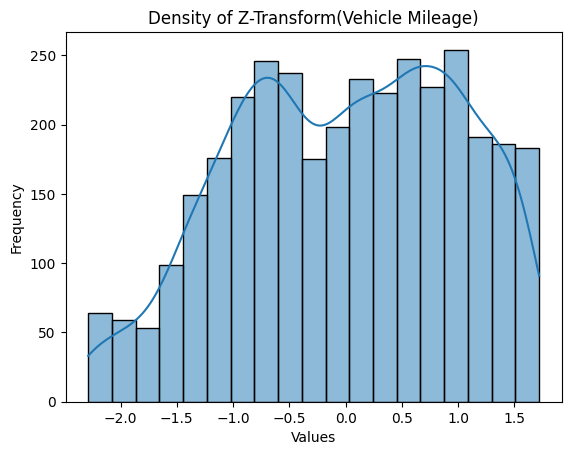

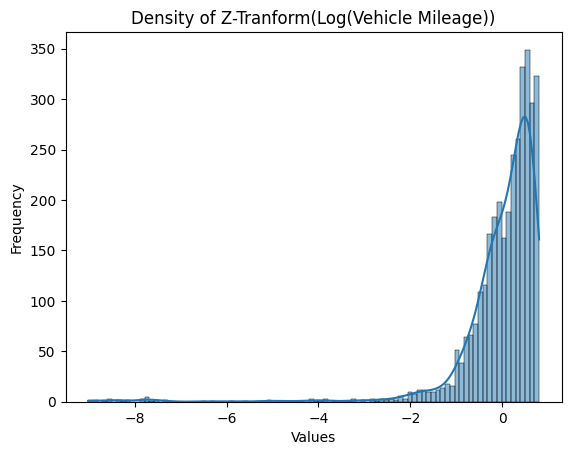

In [1723]:
plotDist(feat_ptrj,"Density of Vehicle Mileage")
plotDist(np.log(feat_ptrj),"Density of Log(Vehicle Mileage)")
plotDist(zScoreTransform(feat_ptrj),"Density of Z-Transform(Vehicle Mileage)")
plotDist(zScoreTransform(np.log(feat_ptrj)),"Density of Z-Tranform(Log(Vehicle Mileage))")

In [1724]:
#ORIGINAL DATA LOOKS ~NORMAL~

same_cols.append(column)
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehmodel
Grand Cherokee    3420
Name: count, dtype: int64
vehmodel
XT5    1570
Name: count, dtype: int64


In [1725]:
#ALREADY HAVE JEEP/CADILLAC ENCODED COLUMNS WHICH HAVE A DIRECT CORRELATION TO THIS
#WILL REMOVE THIS EXTRANEOUS COLUMN
feats_to_drop.append(column)

col+=1 
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehpricelabel
Good Deal     2484
Great Deal     508
Fair Price     428
Name: count, dtype: int64
vehpricelabel
Good Deal     1250
Great Deal     186
Fair Price     134
Name: count, dtype: int64


In [1726]:
encoded_cols.append(column)

col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
feat_ptrc,column = setFeatPtr(input_caddys,col)
feat_ptrj.head()

listingid
4777     Backed by a rigorous 125-point inspection by f...
6242     Drop by to see us and you will quickly see how...
10882    Priced below KBB Fair Purchase Price! Clean CA...
12013    2017 Jeep Grand Cherokee Laredo True Blue Pear...
12334    BLIND SPOT/CROSS PATH DETECTION, APPLE CARPLAY...
Name: vehsellernotes, dtype: object

In [1727]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
tfidfj = TfidfVectorizer(max_df=.50,max_features=60)
tf_revj = tfidfj.fit(feat_ptrj.copy())
vocab2j = tf_idfTokenizer(feat_ptrj,tf_revj)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
vocab2j.head()

,4wd,6l,all,amp,as,auto,automatic,black,bluetooth,br,...,up,us,v6,vehicles,warranty,wheel,wheels,will,x27,x3d
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.000000,0.000000,0.159555,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.171019,0.308908,0.000000,0.0,0.165515,0.000000,0.000000,0.000000,0.156198,0.0
6242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.343764,0.000000,0.0,0.000000,0.000000,0.000000,0.777900,0.347645,0.0
10882,0.148115,0.160205,0.000000,0.000000,0.000000,0.000000,0.151473,0.0,0.000000,0.000000,...,0.000000,0.000000,0.150977,0.0,0.166317,0.000000,0.166582,0.175603,0.000000,0.0
12013,0.108562,0.000000,0.352540,0.148565,0.440374,0.000000,0.111023,0.0,0.111715,0.000000,...,0.125957,0.000000,0.000000,0.0,0.121903,0.111063,0.122097,0.000000,0.230082,0.0
12334,0.124005,0.000000,0.134230,0.000000,0.000000,0.157404,0.000000,0.0,0.000000,0.451313,...,0.287750,0.000000,0.000000,0.0,0.139244,0.000000,0.000000,0.000000,0.262812,0.0


In [1728]:
#ELIMINATE WORDS THAT APPEAR IN MORE THAN max_doc_freq OF DOCUMENTS (DOCUMENT ~ ROW)
#WILL GET RID OF COMMON WORDS SUCH AS "THE", "A", etc.
#LIMIT VOCABULARY TO max_feats COLUMNS (ONE FOR EACH WORD)
tfidfc = TfidfVectorizer(max_df=.50,max_features=60)
tf_revc = tfidfc.fit(feat_ptrc.copy())
vocab2c = tf_idfTokenizer(feat_ptrc,tf_revc)
#THOUGHT: TUNE THE HYPERPARAMETERS TO OPTIMIZE THE TOKENIZER?
vocab2c.head()

,2017,6l,alert,all,amp,are,assist,at,be,call,...,this,us,v6,vehicles,warranty,wheel,will,x27,x3d,your
listingid,,,,,,,,,,,,,,,,,,,,,
7108,0.0,0.0,0.0,0.000000,0.000000,0.195364,0.121573,0.095904,0.000000,0.000000,...,0.098747,0.231728,0.0,0.101986,0.000000,0.110024,0.119530,0.216169,0.0,0.308417
21448,0.0,0.0,0.0,0.000000,0.000000,0.259235,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.135329,0.000000,0.000000,0.317216,0.000000,0.0,0.545664
21807,0.0,0.0,0.0,0.000000,0.194211,0.000000,0.000000,0.147205,0.000000,0.000000,...,0.000000,0.177843,0.0,0.000000,0.517238,0.000000,0.183471,0.000000,0.0,0.000000
30524,0.0,0.0,0.0,0.170694,0.000000,0.331159,0.000000,0.000000,0.214261,0.000000,...,0.334768,0.000000,0.0,0.172875,0.190402,0.000000,0.202614,0.000000,0.0,0.000000
34061,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.224589,0.177168,0.000000,0.321063,...,0.182420,0.107021,0.0,0.188405,0.000000,0.101626,0.000000,0.299505,0.0,0.000000


In [1729]:
#DROP ORIGINAL STATE COLUMN AND LATER REPLACE WITH ENCODED MATRIX COLUMNS
feats_to_drop.append(column)
tokenize_cols.append(column)
input_jeeps.head()

,sellercity,sellerispriv,sellerlistsrc,sellername,sellerrating,sellerrevcnt,sellerstate,sellerzip,vehbodystyle,vehcertified,...,vehmileage,vehmodel,vehpricelabel,vehsellernotes,vehtype,vehtransmission,vehyear,EngineSize,Cylinders,Owners
listingid,,,,,,,,,,,,,,,,,,,,,
4777,17,False,Jeep Certified Program,Wilde Chrysler Jeep Dodge Ram &amp; Subaru,4.8,1405,WI,53186.0,SUV,1,...,38957.0,Grand Cherokee,Good Deal,Backed by a rigorous 125-point inspection by f...,Used,8-Speed Automatic w/OD,2015,3.6,6,1
6242,4,False,Inventory Command Center,Century Dodge Chrysler Jeep RAM,4.4,21,MO,63385.0,SUV,0,...,20404.0,Grand Cherokee,Good Deal,Drop by to see us and you will quickly see how...,Used,Automatic,2018,3.6,6,1
10882,2,False,Digital Motorworks (DMi),Paul Brown Chrysler Dodge Jeep RAM Kia,3.0,51,NY,14760.0,SUV,0,...,34649.0,Grand Cherokee,Good Deal,Priced below KBB Fair Purchase Price! Clean CA...,Used,8-Speed Automatic,2018,3.6,6,1
12013,3,False,Digital Motorworks (DMi),Sierra Motor Mall,3.5,17,IL,61350.0,SUV,0,...,48814.0,Grand Cherokee,Good Deal,2017 Jeep Grand Cherokee Laredo True Blue Pear...,Used,8-Speed Automatic,2017,3.6,6,1
12334,25,False,Digital Motorworks (DMi),Larry Roesch Dodge Chrysler Jeep RAM,4.6,240,IL,60126.0,SUV,0,...,29095.0,Grand Cherokee,Great Deal,"BLIND SPOT/CROSS PATH DETECTION, APPLE CARPLAY...",Used,8-Speed Automatic,2018,3.6,6,1


In [1730]:
vocabjs = pd.merge(vocab1j,vocab2j,left_index=True,right_index=True)
vocabcs = pd.merge(vocab1c,vocab2c,left_index=True,right_index=True)
vocabjs.head()

,air,alarm,alloy,aluminum,am,anti,antilock,auto_x,automatic_x,auxiliary,...,up,us,v6,vehicles,warranty,wheel,wheels_y,will,x27,x3d
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.000000,0.000000,0.0,0.362589,0.260283,0.000000,0.000000,0.359060,0.261243,0.329415,...,0.171019,0.308908,0.000000,0.0,0.165515,0.000000,0.000000,0.000000,0.156198,0.0
6242,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.397475,0.426209,0.000000,0.391020,...,0.000000,0.343764,0.000000,0.0,0.000000,0.000000,0.000000,0.777900,0.347645,0.0
10882,0.000000,0.303521,0.0,0.000000,0.000000,0.292306,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.150977,0.0,0.166317,0.000000,0.166582,0.175603,0.000000,0.0
12013,0.289613,0.000000,0.0,0.000000,0.256202,0.000000,0.000000,0.000000,0.257148,0.000000,...,0.125957,0.000000,0.000000,0.0,0.121903,0.111063,0.122097,0.000000,0.230082,0.0
12334,0.000000,0.303521,0.0,0.000000,0.000000,0.292306,0.000000,0.000000,0.000000,0.000000,...,0.287750,0.000000,0.000000,0.0,0.139244,0.000000,0.000000,0.000000,0.262812,0.0


In [1731]:
vocabcs.head()

,all_x,aluminum,android,apple,assist_x,auto,automatic,auxiliary,beverage,blind,...,this,us,v6,vehicles,warranty,wheel,will,x27,x3d,your
listingid,,,,,,,,,,,,,,,,,,,,,
7108,0.0,0.273007,0.000000,0.000000,0.000000,0.305368,0.318800,0.000000,0.000000,0.0,...,0.098747,0.231728,0.0,0.101986,0.000000,0.110024,0.119530,0.216169,0.0,0.308417
21448,0.0,0.000000,0.308276,0.315974,0.000000,0.274410,0.572961,0.325261,0.000000,0.0,...,0.000000,0.000000,0.0,0.135329,0.000000,0.000000,0.317216,0.000000,0.0,0.545664
21807,0.0,0.169650,0.213179,0.218502,0.186359,0.189760,0.198107,0.449849,0.000000,0.0,...,0.000000,0.177843,0.0,0.000000,0.517238,0.000000,0.183471,0.000000,0.0,0.000000
30524,0.0,0.000000,0.000000,0.000000,0.332808,0.000000,0.353788,0.000000,0.000000,0.0,...,0.334768,0.000000,0.0,0.172875,0.190402,0.000000,0.202614,0.000000,0.0,0.000000
34061,0.0,0.279240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.317566,0.0,...,0.182420,0.107021,0.0,0.188405,0.000000,0.101626,0.000000,0.299505,0.0,0.000000


In [1732]:
col+=1
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehtype
Used    3420
Name: count, dtype: int64
vehtype
Used    1570
Name: count, dtype: int64


In [1733]:
#ENTIRE COLUMN HAS VALUE "USED".....  DROPPING....
feats_to_drop.append(column)

col+=1 
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehtransmission
8-Speed Automatic                2377
8-Speed Automatic w/OD            596
Automatic                         189
Automatic 8-Speed                  54
8-Speed Automatic (845RE)          48
AUTOMATIC                          41
8-Speed Shiftable Automatic        36
8-Speed A/T                        33
8-Speed Automatic (850RE)          11
8-Spd TorqueFlite Automatic         7
8 Speed Automatic                   6
8-Speed Automatic (8HP70)           5
8-Speed                             4
Automatic, 8-Spd                    2
8 speed automatic                   2
8-Spd Auto 850RE Trans (Make        1
8-SPEED AUTOMATIC                   1
AUTO                                1
8-Speed TorqueFlite Automatic       1
Automatic w/OD                      1
aujtomatic                          1
A                                   1
Not Specified                       1
8-Spd Auto 850RE Trans (Make)       1
Name: count, dtype: int64
vehtransmission
8-Speed Automatic             

In [1734]:
#BASICALLY ALL 8-SPEED SO IT GETS DROPPED
feats_to_drop.append(column)

col+=1 
feat_ptrj,column = setFeatPtr(input_jeeps,col)
print(feat_ptrj.value_counts())
feat_ptrc,column = setFeatPtr(input_caddys,col)
print(feat_ptrc.value_counts())

vehyear
2015    1278
2017     863
2018     861
2016     380
2019      38
Name: count, dtype: int64
vehyear
2018    798
2017    698
2019     74
Name: count, dtype: int64


In [1735]:
#ONLY 5 UNIQUES IN OUR DATASET SO WE WILL ONE HOT ENCODE THE CATEGORIES
agej = calculate_age(feat_ptrj)
agec = calculate_age(feat_ptrc)

input_jeeps[column] =  agej
input_caddys[column] = agec

same_cols.append(column)

print(encoded_cols)
print(self_encodej)
print(self_encodec)
print(tokenize_cols)

['sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel', 'vehpricelabel']
           black_x  blue_x  brown_x  green  metallic  pearlcoat  clearcoat  \
listingid                                                                    
4777             1       0        0      0         0          1          0   
6242             1       0        0      0         0          1          0   
10882            0       0        0      0         1          0          1   
12013            0       1        0      0         0          1          0   
12334            0       0        0      0         0          0          0   
...            ...     ...      ...    ...       ...        ...        ...   
8610847          0       0        1      0         1          0          1   
8612731          1       0        0      0         0          1          0   
8614177          1       0        0      0         0          0          0   
8615510          0       0        0      0         0          0 

In [1736]:
feats_handled = (log_cols+encoded_cols+freq_cols+same_cols+mask_cols+tokenize_cols+orig_cols)
#print(orig_cols)
print("HANDLED FEATS:",feats_handled)
print("FEATS TO DROP:",feats_to_drop)


overlap = list(set(feats_handled) & set(feats_to_drop))

print("Overlapping elements:", overlap)
print("SIZE IS 26: ", len(feats_handled+feats_to_drop)-len(overlap)==26)

HANDLED FEATS: ['vehlistdays', 'sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel', 'vehpricelabel', 'sellercity', 'sellerrating', 'sellerrevcnt', 'vehmake', 'vehmileage', 'vehyear', 'vehcertified', 'vehfeats', 'vehsellernotes', 'vehcolorext', 'vehcolorint', 'vehdrivetrain', 'vehengine', 'vehhistory']
FEATS TO DROP: ['sellerispriv', 'sellername', 'sellerzip', 'vehbodystyle', 'vehcolorext', 'vehcolorint', 'vehengine', 'vehfeats', 'vehhistory', 'vehmodel', 'vehsellernotes', 'vehtype', 'vehtransmission']
Overlapping elements: ['vehsellernotes', 'vehengine', 'vehcolorint', 'vehfeats', 'vehcolorext', 'vehhistory']
SIZE IS 26:  False


In [1737]:
feats_to_drop = [col.strip().lower() for col in feats_to_drop]
input_jeeps.columns = [col.strip().lower() for col in input_jeeps.columns]
input_jeeps.drop(columns=feats_to_drop,inplace=True)
input_jeeps.head()

,sellercity,sellerlistsrc,sellerrating,sellerrevcnt,sellerstate,vehcertified,vehdrivetrain,vehfuel,vehlistdays,vehmake,vehmileage,vehpricelabel,vehyear,enginesize,cylinders,owners
listingid,,,,,,,,,,,,,,,,
4777,17,Jeep Certified Program,4.8,1405,WI,1,_4_wd,Gasoline,29.0,Jeep,38957.0,Good Deal,9,3.6,6,1
6242,4,Inventory Command Center,4.4,21,MO,0,_4_wd,Gasoline,60.0,Jeep,20404.0,Good Deal,6,3.6,6,1
10882,2,Digital Motorworks (DMi),3.0,51,NY,0,_4_wd,Gasoline,31.0,Jeep,34649.0,Good Deal,6,3.6,6,1
12013,3,Digital Motorworks (DMi),3.5,17,IL,0,_4_wd,Gasoline,195.0,Jeep,48814.0,Good Deal,7,3.6,6,1
12334,25,Digital Motorworks (DMi),4.6,240,IL,0,_4_wd,Gasoline,29.0,Jeep,29095.0,Great Deal,6,3.6,6,1


In [1738]:
input_caddys.columns = [col.strip().lower() for col in input_caddys.columns]
input_caddys.drop(columns=feats_to_drop,inplace=True)
input_caddys.head()

,sellercity,sellerlistsrc,sellerrating,sellerrevcnt,sellerstate,vehcertified,vehdrivetrain,vehfuel,vehlistdays,vehmake,vehmileage,vehpricelabel,vehyear,enginesize,cylinders,owners
listingid,,,,,,,,,,,,,,,,
7108,2,HomeNet Automotive,3.7,74,AR,0,fwd,Gasoline,99.0,Cadillac,19788.0,Good Deal,6,3.6,6,1
21448,3,HomeNet Automotive,3.7,629,LA,0,fwd,Gasoline,6.0,Cadillac,21098.0,Good Deal,6,3.6,6,1
21807,4,HomeNet Automotive,4.9,360,FL,1,fwd,Gasoline,7.0,Cadillac,3547.0,Good Deal,5,3.6,6,1
30524,3,Digital Motorworks (DMi),5.0,4,TX,0,fwd,Gasoline,12.0,Cadillac,12146.0,Good Deal,7,3.6,6,1
34061,2,Digital Motorworks (DMi),4.3,312,TX,0,fwd,Gasoline,26.0,Cadillac,28293.0,Good Deal,6,3.6,6,1


In [1739]:
input_jeeps = pd.merge(input_jeeps,self_encodej,left_index=True,right_index=True)
print(self_encodej.columns)
input_jeeps.info()

Index(['black_x', 'blue_x', 'brown_x', 'green', 'metallic', 'pearlcoat',
       'clearcoat', 'granite', 'red_x', 'silver_x', 'white', 'none_x',
       'black_y', 'blue_y', 'brown_y', 'beige', 'trim', 'red_y', 'silver_y',
       'frost', 'maple', 'tan', 'cirrus', 'carbon', 'plum', 'none_y',
       'Accident(s) Reported', 'Buyback Protection Eligible',
       'Non-Personal Use Reported', 'Title Issue(s) Reported',
       'None of the above'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 3420 entries, 4777 to 8620012
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sellercity                   3420 non-null   int64  
 1   sellerlistsrc                3420 non-null   object 
 2   sellerrating                 3420 non-null   float64
 3   sellerrevcnt                 3420 non-null   int64  
 4   sellerstate                  3420 non-null   object 
 5   vehcertified  

In [1740]:
input_caddys = pd.merge(input_caddys,self_encodec,left_index=True,right_index=True)
print(self_encodec.columns)
input_caddys.info()

Index(['black_x', 'blue_x', 'brown_x', 'green', 'metallic', 'pearlcoat',
       'clearcoat', 'granite', 'red_x', 'silver_x', 'white', 'none_x',
       'black_y', 'blue_y', 'brown_y', 'beige', 'trim', 'red_y', 'silver_y',
       'frost', 'maple', 'tan', 'cirrus', 'carbon', 'plum', 'none_y',
       'Accident(s) Reported', 'Buyback Protection Eligible',
       'Non-Personal Use Reported', 'Title Issue(s) Reported',
       'None of the above'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 7108 to 8617378
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sellercity                   1570 non-null   int64  
 1   sellerlistsrc                1570 non-null   object 
 2   sellerrating                 1570 non-null   float64
 3   sellerrevcnt                 1570 non-null   int64  
 4   sellerstate                  1570 non-null   object 
 5   vehcertified  

In [1741]:
temp_encodedj = input_jeeps[encoded_cols]
print(encoded_cols)
print(temp_encodedj.columns)

['sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel', 'vehpricelabel']
Index(['sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel',
       'vehpricelabel'],
      dtype='object')


In [1742]:
encoderj = OneHotEncoder(handle_unknown='ignore')
coderj = encoderj.fit(temp_encodedj)
temp_encodedj.columns = temp_encodedj.columns.astype(str)
temp_encodedj = oHotEncode(temp_encodedj,coderj)
temp_encodedj.head()

,Digital Motorworks (DMi),HomeNet Automotive,Inventory Command Center,Jeep Certified Program,My Dealer Center,AL,AR,GA,IA,IL,...,_4_wd,awd,hybrid,Diesel,E85 Flex Fuel,Gasoline,Unknown,Fair Price,Good Deal,Great Deal
listingid,,,,,,,,,,,,,,,,,,,,,
4777,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6242,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10882,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12334,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [1743]:
temp_encodedc = input_caddys[encoded_cols]
print(temp_encodedc.columns)

Index(['sellerlistsrc', 'sellerstate', 'vehdrivetrain', 'vehfuel',
       'vehpricelabel'],
      dtype='object')


In [1744]:
encoderc = OneHotEncoder(handle_unknown='ignore')
coderc = encoderc.fit(temp_encodedc)
temp_encodedc.columns = temp_encodedc.columns.astype(str)
temp_encodedc = oHotEncode(temp_encodedc,coderc)
temp_encodedc.head()

,Digital Motorworks (DMi),HomeNet Automotive,Inventory Command Center,My Dealer Center,AK,AL,AR,AZ,CA,CO,...,VT,WA,WI,WV,awd,fwd,Gasoline,Fair Price,Good Deal,Great Deal
listingid,,,,,,,,,,,,,,,,,,,,,
7108,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
21448,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
21807,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
30524,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
34061,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [1745]:
input_jeeps.drop(columns=encoded_cols,inplace=True)
post_feat_engj = pd.merge(input_jeeps,temp_encodedj,left_index=True, right_index=True)
post_feat_engj.head()

,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmake,vehmileage,vehyear,enginesize,cylinders,...,_4_wd,awd,hybrid,Diesel,E85 Flex Fuel,Gasoline,Unknown,Fair Price,Good Deal,Great Deal
listingid,,,,,,,,,,,,,,,,,,,,,
4777,17,4.8,1405,1,29.0,Jeep,38957.0,9,3.6,6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6242,4,4.4,21,0,60.0,Jeep,20404.0,6,3.6,6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10882,2,3.0,51,0,31.0,Jeep,34649.0,6,3.6,6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12013,3,3.5,17,0,195.0,Jeep,48814.0,7,3.6,6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12334,25,4.6,240,0,29.0,Jeep,29095.0,6,3.6,6,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [1746]:
input_caddys.drop(columns=encoded_cols,inplace=True)
post_feat_engc = pd.merge(input_caddys,temp_encodedc,left_index=True, right_index=True)
post_feat_engc.head()

,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmake,vehmileage,vehyear,enginesize,cylinders,...,VT,WA,WI,WV,awd,fwd,Gasoline,Fair Price,Good Deal,Great Deal
listingid,,,,,,,,,,,,,,,,,,,,,
7108,2,3.7,74,0,99.0,Cadillac,19788.0,6,3.6,6,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
21448,3,3.7,629,0,6.0,Cadillac,21098.0,6,3.6,6,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
21807,4,4.9,360,1,7.0,Cadillac,3547.0,5,3.6,6,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
30524,3,5.0,4,0,12.0,Cadillac,12146.0,7,3.6,6,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
34061,2,4.3,312,0,26.0,Cadillac,28293.0,6,3.6,6,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [1747]:
post_feat_engj = pd.merge(post_feat_engj,vocabjs,left_index=True, right_index=True)
post_feat_engj.head()

,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmake,vehmileage,vehyear,enginesize,cylinders,...,up,us,v6,vehicles,warranty,wheel,wheels_y,will,x27,x3d
listingid,,,,,,,,,,,,,,,,,,,,,
4777,17,4.8,1405,1,29.0,Jeep,38957.0,9,3.6,6,...,0.171019,0.308908,0.000000,0.0,0.165515,0.000000,0.000000,0.000000,0.156198,0.0
6242,4,4.4,21,0,60.0,Jeep,20404.0,6,3.6,6,...,0.000000,0.343764,0.000000,0.0,0.000000,0.000000,0.000000,0.777900,0.347645,0.0
10882,2,3.0,51,0,31.0,Jeep,34649.0,6,3.6,6,...,0.000000,0.000000,0.150977,0.0,0.166317,0.000000,0.166582,0.175603,0.000000,0.0
12013,3,3.5,17,0,195.0,Jeep,48814.0,7,3.6,6,...,0.125957,0.000000,0.000000,0.0,0.121903,0.111063,0.122097,0.000000,0.230082,0.0
12334,25,4.6,240,0,29.0,Jeep,29095.0,6,3.6,6,...,0.287750,0.000000,0.000000,0.0,0.139244,0.000000,0.000000,0.000000,0.262812,0.0


In [1748]:
post_feat_engc = pd.merge(post_feat_engc,vocabcs,left_index=True, right_index=True)
post_feat_engc.head()

,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmake,vehmileage,vehyear,enginesize,cylinders,...,this,us,v6,vehicles,warranty,wheel,will,x27,x3d,your
listingid,,,,,,,,,,,,,,,,,,,,,
7108,2,3.7,74,0,99.0,Cadillac,19788.0,6,3.6,6,...,0.098747,0.231728,0.0,0.101986,0.000000,0.110024,0.119530,0.216169,0.0,0.308417
21448,3,3.7,629,0,6.0,Cadillac,21098.0,6,3.6,6,...,0.000000,0.000000,0.0,0.135329,0.000000,0.000000,0.317216,0.000000,0.0,0.545664
21807,4,4.9,360,1,7.0,Cadillac,3547.0,5,3.6,6,...,0.000000,0.177843,0.0,0.000000,0.517238,0.000000,0.183471,0.000000,0.0,0.000000
30524,3,5.0,4,0,12.0,Cadillac,12146.0,7,3.6,6,...,0.334768,0.000000,0.0,0.172875,0.190402,0.000000,0.202614,0.000000,0.0,0.000000
34061,2,4.3,312,0,26.0,Cadillac,28293.0,6,3.6,6,...,0.182420,0.107021,0.0,0.188405,0.000000,0.101626,0.000000,0.299505,0.0,0.000000


In [1749]:
types = post_feat_engj.select_dtypes(include=['object'])

# Display the object-type columns
print(types)

          vehmake owners
listingid               
4777         Jeep      1
6242         Jeep      1
10882        Jeep      1
12013        Jeep      1
12334        Jeep      1
...           ...    ...
8610847      Jeep      1
8612731      Jeep      1
8614177      Jeep      1
8615510      Jeep      1
8620012      Jeep      1

[3420 rows x 2 columns]


In [1750]:
post_feat_engj["owners"] = pd.to_numeric(post_feat_engj["owners"], errors='coerce').fillna(0).astype(int)
print(post_feat_engj["owners"].value_counts())
post_feat_engj.columns = post_feat_engj.columns.astype(str)
post_feat_engj.info()

owners
1    3057
2     219
0     129
3      12
4       3
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3420 entries, 4777 to 8620012
Columns: 168 entries, sellercity to x3d
dtypes: float64(130), int32(29), int64(8), object(1)
memory usage: 4.2+ MB


In [1751]:
post_feat_engc["owners"] = pd.to_numeric(post_feat_engc["owners"], errors='coerce').fillna(0).astype(int)
print(post_feat_engc["owners"].value_counts())
post_feat_engc.columns = post_feat_engc.columns.astype(str)
post_feat_engc.info()

owners
1    1368
0     118
2      79
3       4
4       1
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1570 entries, 7108 to 8617378
Columns: 190 entries, sellercity to your
dtypes: float64(152), int32(29), int64(8), object(1)
memory usage: 2.1+ MB


In [1752]:
columnsj_missing = post_feat_engj.columns[post_feat_engj.isna().any()].tolist()

# Display columns with missing values
print("Columns with missing values:", columnsj_missing)

Columns with missing values: []


In [1753]:
columnsc_missing = post_feat_engc.columns[post_feat_engc.isna().any()].tolist()

# Display columns with missing values
print("Columns with missing values:", columnsc_missing)

Columns with missing values: []


In [1754]:
print(post_feat_engj.isna().sum().sum())
post_feat_engj.head()

0


,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmake,vehmileage,vehyear,enginesize,cylinders,...,up,us,v6,vehicles,warranty,wheel,wheels_y,will,x27,x3d
listingid,,,,,,,,,,,,,,,,,,,,,
4777,17,4.8,1405,1,29.0,Jeep,38957.0,9,3.6,6,...,0.171019,0.308908,0.000000,0.0,0.165515,0.000000,0.000000,0.000000,0.156198,0.0
6242,4,4.4,21,0,60.0,Jeep,20404.0,6,3.6,6,...,0.000000,0.343764,0.000000,0.0,0.000000,0.000000,0.000000,0.777900,0.347645,0.0
10882,2,3.0,51,0,31.0,Jeep,34649.0,6,3.6,6,...,0.000000,0.000000,0.150977,0.0,0.166317,0.000000,0.166582,0.175603,0.000000,0.0
12013,3,3.5,17,0,195.0,Jeep,48814.0,7,3.6,6,...,0.125957,0.000000,0.000000,0.0,0.121903,0.111063,0.122097,0.000000,0.230082,0.0
12334,25,4.6,240,0,29.0,Jeep,29095.0,6,3.6,6,...,0.287750,0.000000,0.000000,0.0,0.139244,0.000000,0.000000,0.000000,0.262812,0.0


In [1755]:
print(post_feat_engc.isna().sum().sum())
post_feat_engc.head()

0


,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmake,vehmileage,vehyear,enginesize,cylinders,...,this,us,v6,vehicles,warranty,wheel,will,x27,x3d,your
listingid,,,,,,,,,,,,,,,,,,,,,
7108,2,3.7,74,0,99.0,Cadillac,19788.0,6,3.6,6,...,0.098747,0.231728,0.0,0.101986,0.000000,0.110024,0.119530,0.216169,0.0,0.308417
21448,3,3.7,629,0,6.0,Cadillac,21098.0,6,3.6,6,...,0.000000,0.000000,0.0,0.135329,0.000000,0.000000,0.317216,0.000000,0.0,0.545664
21807,4,4.9,360,1,7.0,Cadillac,3547.0,5,3.6,6,...,0.000000,0.177843,0.0,0.000000,0.517238,0.000000,0.183471,0.000000,0.0,0.000000
30524,3,5.0,4,0,12.0,Cadillac,12146.0,7,3.6,6,...,0.334768,0.000000,0.0,0.172875,0.190402,0.000000,0.202614,0.000000,0.0,0.000000
34061,2,4.3,312,0,26.0,Cadillac,28293.0,6,3.6,6,...,0.182420,0.107021,0.0,0.188405,0.000000,0.101626,0.000000,0.299505,0.0,0.000000


In [1756]:
output_data = pd.DataFrame(df_train.iloc[:,-2:].copy())
output_jeeps = output_data[df_train["vehmake"] == "Jeep"].copy()
output_caddys = output_data[df_train["vehmake"] == "Cadillac"].copy()
print(output_jeeps["vehicle_trim"].value_counts())
print(output_caddys["vehicle_trim"].value_counts())

vehicle_trim
Limited             1621
Laredo               658
Overland             342
Altitude             331
Summit               203
Trailhawk            149
SRT                   64
Trackhawk             27
Sterling Edition      25
Name: count, dtype: int64
vehicle_trim
Premium Luxury    702
Luxury            603
Base              137
Platinum          128
Name: count, dtype: int64


In [1757]:
df_test.isna().sum()
test_df = df_test.copy()
test_jeeps = pd.DataFrame(test_df[test_df["VehMake"]=="Jeep"])
test_caddys = pd.DataFrame(test_df[test_df["VehMake"]=="Cadillac"])

In [1758]:
#NOW APPLY THE SAME ENCODING AND TRANSFORMATIONS TO THE TEST DATASET
test_data_jeeps = engineerTestData(test_jeeps,log_cols,encoded_cols,freq_cols,
                             mask_cols,tokenize_cols,orig_cols,feats_to_drop,
                             coderj,tf_featsj,tf_revj)

COLOR
COLOR2
HISTORY


C:\Users\aflyn\AppData\Local\Temp\ipykernel_7912\4162812066.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_encode[col] = temp_df


In [1759]:
#NOW APPLY THE SAME ENCODING AND TRANSFORMATIONS TO THE TEST DATASET
test_data_caddys = engineerTestData(test_caddys,log_cols,encoded_cols,freq_cols,
                             mask_cols,tokenize_cols,orig_cols,feats_to_drop,
                             coderc,tf_featsc,tf_revc)

COLOR


C:\Users\aflyn\AppData\Local\Temp\ipykernel_7912\4162812066.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_encode[col] = temp_df


COLOR2
HISTORY


In [1760]:
print(test_data_jeeps.isna().sum().sum())
print(test_data_jeeps.info())
test_data_jeeps.columns

21
<class 'pandas.core.frame.DataFrame'>
Index: 658 entries, 8625693 to 9997199
Columns: 168 entries, sellercity to x3d
dtypes: float64(130), int32(28), int64(8), object(2)
memory usage: 813.0+ KB
None


Index(['sellercity', 'sellerrating', 'sellerrevcnt', 'vehcertified',
       'vehlistdays', 'vehmake', 'vehmileage', 'vehyear', 'enginesize',
       'cylinders',
       ...
       'up', 'us', 'v6', 'vehicles', 'warranty', 'wheel', 'wheels_y', 'will',
       'x27', 'x3d'],
      dtype='object', length=168)

In [1761]:
print(test_data_caddys.isna().sum().sum())
print(test_data_caddys.info())
test_data_caddys.head()

6
<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 8622015 to 9999562
Columns: 190 entries, sellercity to your
dtypes: float64(152), int32(28), int64(8), object(2)
memory usage: 481.0+ KB
None


,sellercity,sellerrating,sellerrevcnt,vehcertified,vehlistdays,vehmake,vehmileage,vehyear,enginesize,cylinders,...,this,us,v6,vehicles,warranty,wheel,will,x27,x3d,your
listingid,,,,,,,,,,,,,,,,,,,,,
8622015,1,2.5,59,0,4.969813,Cadillac,13625.0,2018,3.6,6,...,0.512856,0.000000,0.000000,0.000000,0.000000,0.000000,0.155200,0.561352,0.0,0.133484
8627430,7,4.6,162,0,3.218876,Cadillac,22269.0,2018,3.6,6,...,0.071357,0.167454,0.000000,0.442191,0.000000,0.079507,0.000000,0.000000,0.0,0.000000
8630863,1,4.7,55,0,3.871201,Cadillac,31828.0,2017,3.6,6,...,0.000000,0.000000,0.224072,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.229662
8636188,5,4.8,59,1,3.091042,Cadillac,25500.0,2017,3.6,6,...,0.116968,0.000000,0.000000,0.000000,0.266106,0.130326,0.141587,0.000000,0.0,0.000000
8639022,1,2.8,18,0,5.099866,Cadillac,21088.0,2018,3.6,6,...,0.000000,0.609719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [1762]:
columns_with_missing_values = test_data_jeeps.columns[test_data_jeeps.isna().any()].tolist()
print(test_data_jeeps.index)
# Display columns with missing values
print("Columns with missing values:", columns_with_missing_values)

Index([8625693, 8625750, 8626885, 8629427, 8629962, 8630638, 8630762, 8632283,
       8649823, 8649882,
       ...
       9983383, 9983736, 9986645, 9986711, 9987122, 9987266, 9989599, 9992170,
       9992442, 9997199],
      dtype='int64', name='listingid', length=658)
Columns with missing values: ['owners']


In [1763]:
columns_with_missing_values = test_data_caddys.columns[test_data_caddys.isna().any()].tolist()
print(test_data_caddys.index)
# Display columns with missing values
print("Columns with missing values:", columns_with_missing_values)

Index([8622015, 8627430, 8630863, 8636188, 8639022, 8639992, 8642278, 8645005,
       8647894, 8649794,
       ...
       9948073, 9953049, 9957979, 9976374, 9981584, 9987374, 9991651, 9993562,
       9994646, 9999562],
      dtype='int64', name='listingid', length=342)
Columns with missing values: ['owners']


In [1764]:
test_data_jeeps["owners"] = pd.to_numeric(test_data_jeeps["owners"], errors='coerce').fillna(0).astype(int)
test_data_caddys["owners"] = pd.to_numeric(test_data_caddys["owners"], errors='coerce').fillna(0).astype(int)

In [1765]:
print(test_data_jeeps.shape)
print(test_data_caddys.shape)
#test_data_jeeps = test_data_jeeps[post_feat_engj.columns]

post_feat_engj.to_csv("postfeatengj.csv")
test_data_jeeps.to_csv("testtransj.csv") 
columns_unique_to_df1 = set(post_feat_engj.columns) - set(test_data_jeeps.columns)
columns_unique_to_df2 = set(test_data_jeeps.columns) - set(post_feat_engj.columns)
common_columns = post_feat_engj.columns.intersection(test_data_jeeps.columns)

print("Columns unique to DataFrame 1:", columns_unique_to_df1)
print("Columns unique to DataFrame 2:", columns_unique_to_df2)
print("Common columns:", common_columns)

(658, 168)
(342, 190)
Columns unique to DataFrame 1: set()
Columns unique to DataFrame 2: set()
Common columns: Index(['sellercity', 'sellerrating', 'sellerrevcnt', 'vehcertified',
       'vehlistdays', 'vehmake', 'vehmileage', 'vehyear', 'enginesize',
       'cylinders',
       ...
       'up', 'us', 'v6', 'vehicles', 'warranty', 'wheel', 'wheels_y', 'will',
       'x27', 'x3d'],
      dtype='object', length=168)


In [1766]:
jeep_encoder = LabelEncoder()
caddy_encoder = LabelEncoder()

pre_encoded_jeeps = output_jeeps["vehicle_trim"]
pre_encoded_caddys = output_caddys["vehicle_trim"]

print(pre_encoded_jeeps.value_counts())
jeep_veh_trim = pd.Series(jeep_encoder.fit_transform(pre_encoded_jeeps),
                     index=post_feat_engj.index,
                     name=pre_encoded_jeeps.name)
caddy_veh_trim = pd.Series(caddy_encoder.fit_transform(pre_encoded_caddys),
                     index=pre_encoded_caddys.index,
                     name=pre_encoded_caddys.name)
print(np.unique(jeep_encoder.inverse_transform(jeep_veh_trim),return_counts=True))

list_pricej = output_jeeps["dealer_listing_price"]
list_pricec = output_caddys["dealer_listing_price"] 

vehicle_trim
Limited             1621
Laredo               658
Overland             342
Altitude             331
Summit               203
Trailhawk            149
SRT                   64
Trackhawk             27
Sterling Edition      25
Name: count, dtype: int64
(array(['Altitude', 'Laredo', 'Limited', 'Overland', 'SRT',
       'Sterling Edition', 'Summit', 'Trackhawk', 'Trailhawk'],
      dtype=object), array([ 331,  658, 1621,  342,   64,   25,  203,   27,  149], dtype=int64))


In [1767]:
post_feat_engj.drop("vehmake", axis=1, inplace=True)
print(jeep_veh_trim.value_counts())

post_feat_engc.drop("vehmake", axis=1, inplace=True)
print(caddy_veh_trim.value_counts())

vehicle_trim
2    1621
1     658
3     342
0     331
6     203
8     149
4      64
7      27
5      25
Name: count, dtype: int64
vehicle_trim
3    702
1    603
0    137
2    128
Name: count, dtype: int64


In [1768]:
clfj = tr.XGB_Classifier(post_feat_engj,jeep_veh_trim,False,jeep_encoder)
clfc = tr.XGB_Classifier(post_feat_engc,caddy_veh_trim,False,caddy_encoder)

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best Score:  0.9834885538329462
Best Parameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best Score:  0.996573713448575


In [1769]:
regj = tr.XGB_Regressor(post_feat_engj,list_pricej,jeep_veh_trim,jeep_encoder,False,True)
regc = tr.XGB_Regressor(post_feat_engc,list_pricec,caddy_veh_trim,caddy_encoder,False,True)

DUMMIES:             Altitude  Laredo  Limited  Overland    SRT  Sterling Edition  \
listingid                                                                 
4777          False    True    False     False  False             False   
6242          False   False     True     False  False             False   
10882         False   False     True     False  False             False   
12013         False    True    False     False  False             False   
12334         False   False     True     False  False             False   
...             ...     ...      ...       ...    ...               ...   
8610847       False   False     True     False  False             False   
8612731        True   False    False     False  False             False   
8614177       False   False     True     False  False             False   
8615510       False   False     True     False  False             False   
8620012       False   False    False     False  False             False   

           Sum

In [1770]:
#TEST VEHICLE TRIM PREDICTIONS
test_data_jeeps.drop("vehmake",axis=1,inplace=True)
clfj.prediction(test_data_jeeps)
print(clfj.preds.isna().sum())
print(clfj.preds.value_counts())

test_data_caddys.drop("vehmake",axis=1,inplace=True)
clfc.prediction(test_data_caddys)
print(clfc.preds.isna().sum())
print(clfc.preds.value_counts())

0
vehicle_trim
Limited      310
Laredo       132
Trailhawk    105
Overland      46
Summit        31
Altitude      14
SRT           12
Trackhawk      8
Name: count, dtype: int64
0
vehicle_trim
Luxury            152
Premium Luxury    145
Base               28
Platinum           17
Name: count, dtype: int64


In [1771]:
percentages = pd.DataFrame({"TEST PREDS" : clfj.preds.value_counts(normalize=True), 
                            "TRAINING LABELS" : pre_encoded_jeeps.value_counts(normalize=True),
                           "Delta": clfj.preds.value_counts(normalize=True)-pre_encoded_jeeps.value_counts(normalize=True)})
percentages

,TEST PREDS,TRAINING LABELS,Delta
vehicle_trim,,,
Altitude,0.021277,0.096784,-0.075507
Laredo,0.200608,0.192398,0.008210
Limited,0.471125,0.473977,-0.002852
Overland,0.069909,0.100000,-0.030091
SRT,0.018237,0.018713,-0.000476
Sterling Edition,NaN,0.007310,NaN
Summit,0.047112,0.059357,-0.012244
Trackhawk,0.012158,0.007895,0.004263
Trailhawk,0.159574,0.043567,0.116007


In [1772]:
exp_pricesj = pr.calc_exp_prices(test_data_jeeps,pre_encoded_jeeps,regj)
exp_pricesc =  pr.calc_exp_prices(test_data_caddys,pre_encoded_caddys,regc)
print(exp_pricesj)

               Altitude        Laredo       Limited      Overland  \
listingid                                                           
8625693    25756.164062  21907.056641  23698.693359  26156.363281   
8625750    26385.759766  22646.736328  24658.150391  26512.519531   
8626885    27069.154297  22745.728516  24902.755859  27051.125000   
8629427    27584.451172  22707.300781  26253.480469  29026.433594   
8629962    28246.298828  22887.773438  25321.275391  27842.763672   
...                 ...           ...           ...           ...   
9987266    27817.167969  23205.978516  25032.058594  27836.431641   
9989599    51206.121094  51095.324219  49973.289062  51318.929688   
9992170    27041.287109  23053.080078  25098.341797  27677.669922   
9992442    28602.177734  24000.957031  26990.851562  29106.378906   
9997199    36055.410156  31074.712891  34910.425781  36129.527344   

                    SRT  Sterling Edition        Summit     Trackhawk  \
listingid                    

In [1773]:
test_preds_pricej = pr.calc_test_prices(test_data_jeeps,clfj,regj,exp_pricesj)
test_preds_pricec = pr.calc_test_prices(test_data_caddys,clfc,regc,exp_pricesc)

In [1774]:
#JEEPS WITHOUT POSTERIOR PROBABILITY
regj.prediction(pd.concat([test_data_jeeps,clfj.preds_proba],axis=1))
predsj = pd.Series(regj.preds,index=test_data_jeeps.index,name=list_pricej.name)
#CADDYS WITHOUT POSTERIOR PROBABILITY
regc.prediction(pd.concat([test_data_caddys,clfc.preds_proba],axis=1))
predsc = pd.Series(regc.preds,index=test_data_caddys.index,name=list_pricec.name)

In [1775]:
#Train a new model without the trims involved
regj_no_trim = tr.XGB_Regressor(post_feat_engj,list_pricej,jeep_veh_trim,jeep_encoder,False,False)
regj_no_trim.prediction(test_data_jeeps)
no_trims = pd.Series(regj_no_trim.preds,index=test_data_jeeps.index,name=list_pricej.name)

           sellercity  sellerrating  sellerrevcnt  vehcertified  vehlistdays  \
listingid                                                                      
4777               17           4.8          1405             1         29.0   
6242                4           4.4            21             0         60.0   
10882               2           3.0            51             0         31.0   
12013               3           3.5            17             0        195.0   
12334              25           4.6           240             0         29.0   
...               ...           ...           ...           ...          ...   
8610847            18           4.8          1016             0        103.0   
8612731             5           4.9           121             1         39.0   
8614177            35           1.5             6             0         40.0   
8615510            27           3.3            16             0          5.0   
8620012            21           3.8     

In [1776]:
desc_stats = pd.DataFrame({'Training Prices': list_pricej.describe(),
                           'Expected Price Prob Calculation': test_preds_pricej.describe(),
                          'Model Prediction with trim probs': predsj.describe(),
                          'Trim Agnostic Preds': no_trims.describe()})

desc_stats

,Training Prices,Expected Price Prob Calculation,Model Prediction with trim probs,Trim Agnostic Preds
count,3420.000000,658.000000,658.000000,658.000000
mean,30113.606725,28063.986990,29893.847656,27783.496094
std,7525.329608,5156.575810,4171.636230,5182.840332
min,18289.000000,20879.755859,25574.521484,20700.306641
25%,25500.000000,25309.351562,27831.250977,25070.467285
50%,28700.000000,27193.409180,29027.985352,26826.882812
75%,32992.000000,29406.104980,30793.535645,29118.433594
max,89500.000000,61332.222656,55165.222656,61724.550781


In [1777]:
#Test Exp price calc on training data


In [1778]:
'''import optuna

# Define the objective function for Optuna
def objective_trim(trial,X_train,y_train):
    # Sample hyperparameters from the search space
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    num_units = trial.suggest_int('num_units', 64, 256)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    batch_size = trial.suggest_int('batch_size', 32, 128)
    hidden_activation = trial.suggest_categorical('hidden_activation', ['relu', 'tanh', 'sigmoid'])
    output_activation = trial.suggest_categorical('output_activation', ['softmax'])

    # Pack hyperparameters into a list
    params = [learning_rate, num_units, dropout_rate, num_layers, batch_size, hidden_activation, output_activation]

    # Call the objective function with the sampled hyperparameters
    return nm.objective_function(params, X_train, y_train, 'trim')

# Run Optuna optimization
study_trim = optuna.create_study(direction='minimize')
study_trim.optimize(lambda trial: objective_trim(trial, post_feat_engj, jeep_veh_trim), n_trials=50,n_jobs=-1)  # You can adjust the number of trials

# Get the best parameters from the optimization
best_params_trim = study_trim.best_params'''

"import optuna\n\n# Define the objective function for Optuna\ndef objective_trim(trial,X_train,y_train):\n    # Sample hyperparameters from the search space\n    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)\n    num_units = trial.suggest_int('num_units', 64, 256)\n    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)\n    num_layers = trial.suggest_int('num_layers', 1, 3)\n    batch_size = trial.suggest_int('batch_size', 32, 128)\n    hidden_activation = trial.suggest_categorical('hidden_activation', ['relu', 'tanh', 'sigmoid'])\n    output_activation = trial.suggest_categorical('output_activation', ['softmax'])\n\n    # Pack hyperparameters into a list\n    params = [learning_rate, num_units, dropout_rate, num_layers, batch_size, hidden_activation, output_activation]\n\n    # Call the objective function with the sampled hyperparameters\n    return nm.objective_function(params, X_train, y_train, 'trim')\n\n# Run Optuna optimization\nstudy_trim = op

In [1779]:
'''best_score = study_trim.best_value

# Print the best score
print(f"Best Score: {best_score}")'''

'best_score = study_trim.best_value\n\n# Print the best score\nprint(f"Best Score: {best_score}")'

In [1780]:
final_jeep_outputs = pd.concat([clfj.preds, test_preds_pricej],axis=1)
final_caddy_outputs = pd.concat([clfc.preds, test_preds_pricec],axis=1)
final_outputs = pd.concat([final_jeep_outputs,final_caddy_outputs],axis=0)

final_outputs.columns = output_data.columns
print(final_outputs)

             vehicle_trim  dealer_listing_price
listingid                                      
8625693           Limited          24052.468750
8625750            Laredo          24194.689453
8626885           Limited          24932.539062
8629427            Laredo          23395.201172
8629962           Limited          25375.408203
...                   ...                   ...
9987374            Luxury          49114.382812
9991651              Base          29097.310547
9993562    Premium Luxury          36400.937500
9994646    Premium Luxury          37623.945312
9999562            Luxury          34753.796875

[1000 rows x 2 columns]


In [1781]:
final_outputs['Index'] = final_outputs.index
final_outputs = final_outputs[['Index',output_data.columns[0],output_data.columns[1]]]
final_outputs.head()

,Index,vehicle_trim,dealer_listing_price
listingid,,,
8625693,8625693,Limited,24052.468750
8625750,8625750,Laredo,24194.689453
8626885,8626885,Limited,24932.539062
8629427,8629427,Laredo,23395.201172
8629962,8629962,Limited,25375.408203


In [1782]:
print(final_outputs.isna().sum())

Index                   0
vehicle_trim            0
dealer_listing_price    0
dtype: int64


In [1783]:
final_outputs.to_csv('submission.csv', index=False, header=False)

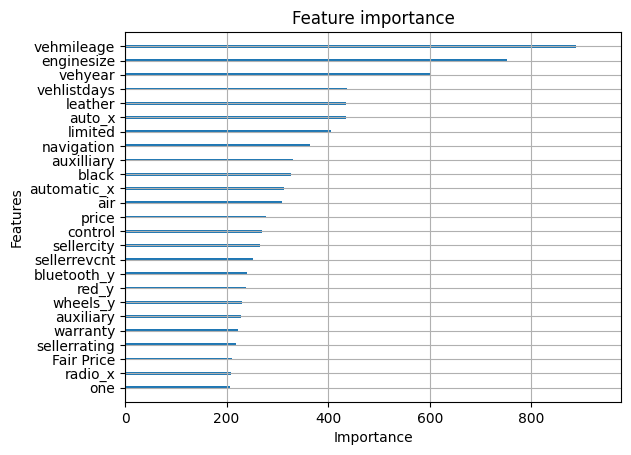

In [1784]:
xgb.plot_importance(clfj.model,max_num_features=25,importance_type='weight', show_values=False, xlabel='Importance', ylabel='Features', orientation='horizontal')
plt.show()

In [1785]:
#Gathering stats using expected price calculation on training data splits
test_exp_j = tr.XGB_Regressor(post_feat_engj,list_pricej,jeep_veh_trim,jeep_encoder,True,True)

test_exp_c = tr.XGB_Regressor(post_feat_engc,list_pricec,caddy_veh_trim,caddy_encoder,True,True)

DUMMIES:             Altitude  Laredo  Limited  Overland    SRT  Sterling Edition  \
listingid                                                                 
5168348       False    True    False     False  False             False   
2467433       False   False     True     False  False             False   
5750036       False   False    False     False  False             False   
6878110       False    True    False     False  False             False   
712545        False   False     True     False  False             False   
...             ...     ...      ...       ...    ...               ...   
6479897       False   False     True     False  False             False   
1143545       False    True    False     False  False             False   
4126695        True   False    False     False  False             False   
3692251       False   False    False     False   True             False   
8037873       False   False     True     False  False             False   

           Sum

C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aflyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\U

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Score:  0.9436365456111278
R2 Score for straight model predict: 0.9486032648829237
R2 Score for Exp price calc: 0.9484412723840386
EXPLAINED VARIANCE  0.9484958705844729
rmse:  1659.662500731377
DUMMIES:              Base  Luxury  Platinum  Premium Luxury
listingid                                         
1284766    False   False     False            True
1578334    False   False     False            True
3629973    False    True     False           False
5133024    False    True     False           False
3762156    False   False     False            True
...          ...     ...       ...             ...
6871295     True   False     False           False
1956592    False    True     False           False
4397435    False   False     False            True
3754507    False   False     False            True
610777     False    True     False           False

[1256 rows x 4 columns]
SECOND :             sel

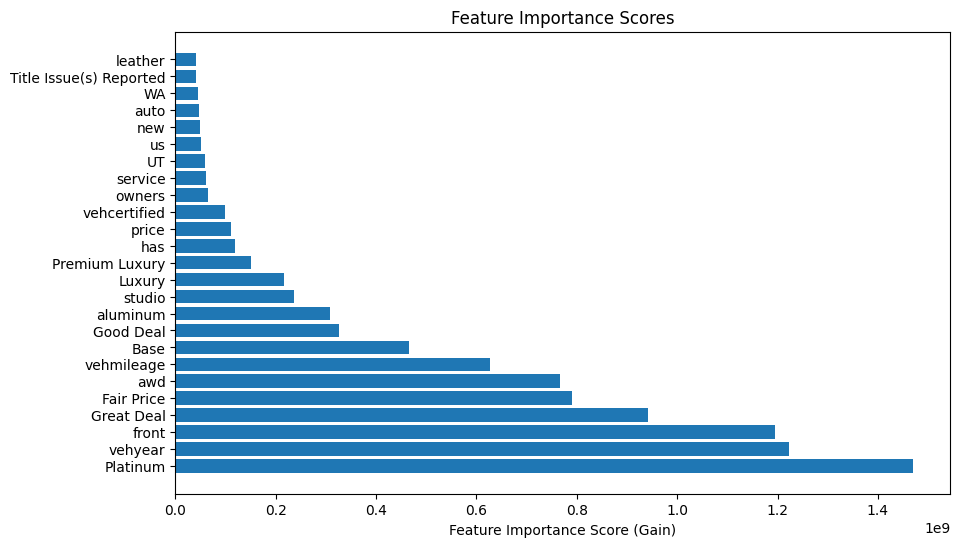

In [1786]:
importance_scores = regc.model.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)[:25]

# Separate feature names and scores for plotting
feature_names, scores = zip(*sorted_importance)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_names)), scores, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance Score (Gain)')
plt.title('Feature Importance Scores')
plt.show()